### Imports

In [1]:
# Add your package imports here
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from scipy.stats import zscore
from scipy.optimize import fmin
from sympy import symbols, expand, Eq, solve, limit, sin, diff, integrate, cos, pi, exp, cot, acos, ln, E, atan, oo, pi, tan
import sympy as sp
from getpass import getpass
from mysql.connector import connect, Error
from xgboost import XGBClassifier
import requests as req

### Load the data

First, I would also like to show the code I used to create the "merged_data.csv" file:

In [3]:
# Initiate list of DataFrames
dfli = []
# Scroll through all files in data/NAC
with os.scandir("data/NAC_xls") as files:
    for file in files:
        if file.is_file():
            # Save file's contents as DataFrame.
            df = pd.read_excel("data/NAC_xls/" + file.name)
            # Add DataFrame to the list
            dfli.append(df)

# Merge DataFrames
df_merged = pd.concat(dfli)

# Write the entire DataFrame to a csv file
df_merged.to_csv("data/merged_data.csv")

You can see I scanned the folder "NAC_xls", searched for all the files in it, saved them into a list of dataframes and meged them all together into one dataframe. This dataframe gets saved into a new file which I will later call to show that it works correctly.

In [4]:
# Load the needed data.
nacdata = pd.read_csv("data/merged_data.csv")

## Data Management and Understanding

### Data Cleansing

In [5]:
# Count the amount of missing values.
print("Amount of missing values:", nacdata.isna().sum().sum())

# Check if there are any missing values, if there are, execute the following code
if(nacdata.isna().sum().sum() != 0):
    # Fill empty values on the numerical columns.
    nacdata.select_dtypes(include="number").fillna(0, inplace=True)

    # Fill empty values for the other columns.
    nacdata.fillna(nacdata.mode().iloc[0], inplace=True)
# Amount of missing values after cleaning.
print("Amount of missing values after removal:", nacdata.isna().sum().sum())

# Drop duplicates in the dataframe.
nacdata.drop_duplicates(inplace=True)

# Following code is to handle outliers
# Only select the numerical columns
outlier_cols = nacdata[["Height", "Red cards", "Non-penalty goals"]].columns

# Calculate the z-score
z_scores = pd.DataFrame(abs(zscore(nacdata[outlier_cols])), columns=outlier_cols)

threshold = 3

# Loop through all numerical columns.
for col in outlier_cols:
    col_z_scores = z_scores[col]
    # calculate the outliers
    outliers = col_z_scores > threshold
    # Get median of that column.
    col_median = nacdata[col].median()
    # Replace outlier with Median.
    nacdata[col] = np.where(outliers, col_median, nacdata[col])

# Turn Position to list
nacdata["Position"] = nacdata["Position"].str.split(", ")

# Create the exploded Position column.
df = nacdata.explode("Position")

# Create bins for range Market Values.
df["Bin"] = np.where(df['Market value'].between(0,150000), 0, 
                                   np.where(df['Market value'].between(150000, 450000), 1, 
                                            np.where(df['Market value'] >= 450000, 2, 0)))

# Save the Positions into groups
df["Position Bin"] = np.where(df['Position'].isin(['LWF', 'RWF', 'RW', 'CF', 'LW']), "Attacker", 
                                   np.where(df["Position"].isin(['RCB', 'LCB', 'LB', 'RB', 'CB', 'RWB', 'LWB']), "Defender", 
                                            np.where(df["Position"].isin(['AMF', 'LAMF', 'RAMF', 'RDMF', 'RCMF', 'LCMF', 'DMF', 'LDMF']), "MidFielder", 
                                                     np.where(df["Position"].str.contains("GK"), "Goalkeeper", "None"))))

Amount of missing values: 120738


Amount of missing values after removal: 0


I will elaborate my choices for data cleaning:
- filling missing numerical data by 0 is to prevent skewing the analysis or models with false numbers
- I fill the missing categorical data with the most occuring value to make sure this won't skew the data with any values like "unkown".
- There are no duplicated rows, so they don't get handled for now. Further below there is some code for handling duplicated rows when I split the dataset into positions.
- I regulated the outliers by selecting only the columns with very extreme and unneeded outliers, calculate each of their z-scores, selecting the outliers and finally changing them to the median of their columns. This process is quicker and more efficient than doing it all by hand.
- "df" is a copy of the nacdata which has the positions exploded, this is to make sure players can be grouped into certain groups like attackers and defenders depending on their position, this group will determine which model they will appear on later on.
- A bin column is created to determine the range of market value in which the players would usually belong.
- Position Bin column is created for seeing which position group they fall in.
- nacdata will be used mostly for analysis and df will mostly be used for models and a couple of analysis which need separate positions. 

### Exploratory Data Analysis 

Next I wanted to see which teams have the higher Market Value and the range of the average Market Values per teams, this would also be important for understanding the dataset and to understand which teams have the highest market values in this dataset. We can see that there is one team with an extremely high Market value: Liverpool. The range of Market Values is the exact same amount, meaning that there is a team with an average Market Value of 0.

In [7]:
# Get the teams with the highest Market Value.
mean_mv = nacdata.groupby("Team")["Market value"].mean().sort_values(ascending=False)

# Print out the top 5 teams
print("Top 5 teams based on average Market Value", mean_mv.head(5))

# Print out the range of average market values.
print("Range of Market Values per team:", mean_mv.max() - mean_mv.min())

Top 5 teams based on average Market Value Team
Liverpool          60000000.0
West Ham United    35000000.0
Chelsea            28000000.0
Arsenal            21750000.0
RB Leipzig         17600000.0
Name: Market value, dtype: float64
Range of Market Values per team: 60000000.0


Next I was interested in the distribution of Positions, to see what the most famous positions are in this dataset. Looking at the result, we can conclude that CF is the most frequent position in the dataset. The top 3 most frequent positions are mostly in CF (Frontline) and LCMF and RCMF, which are MidField positions.

In [10]:
# Print the amount of occurences per position, sorted descending.
df["Position"].value_counts().sort_values(ascending=False)

Position
CF      3670
LCMF    2729
RCMF    2679
LCB     2217
RCB     2212
LB      1920
RB      1919
AMF     1805
RW      1744
LW      1663
DMF     1314
GK      1280
LAMF    1075
RAMF    1069
CB       888
RDMF     836
LDMF     831
RWB      739
LWB      713
RWF      703
LWF      697
Name: count, dtype: int64

Next I did some research on the countries which appeared the most frequently in the dataset. I decided to only show the top 20 here to make sure the big amount of data won't get in the way. It looks like the most players are born in Europe, there are only a few countries outside of Europe which a good amount of players originate from.

In [11]:
# Print out the amount of people born in certain countries.
print(nacdata["Birth country"].value_counts().head(20))

Birth country
Italy             1871
Germany           1150
France             986
Spain              945
Netherlands        689
Portugal           670
Czech Republic     629
Hungary            592
Sweden             578
Norway             506
Denmark            494
Austria            493
Belgium            432
Brazil             418
Israel             326
Croatia            323
Iceland            307
Romania            294
Slovakia           278
Poland             259
Name: count, dtype: int64


Now I wanted to see what the correlations between Height and Goals or what the correlation between Weight and Goals is. We can see that they both have a correlation of 0.06, which can be rounded to 0, making it a correlation of 0, meaning there is absolutely no correlation between either of these datapoints. For more insights I will show a visualization under the Visualizations tab of this page.

In [12]:
# print out the correlations
print("Correlation between Weight and Goals:", nacdata[["Weight", "Goals"]].corr()["Goals"]["Weight"])
print("Correlation between Height and Goals:", nacdata[["Height", "Goals"]].corr()["Goals"]["Height"])

Correlation between Weight and Goals: 0.06356411494504172
Correlation between Height and Goals: 0.06499178577864122


Next I want to see the Median of the Amount of Goals per Position. From this result we can conclude the following: The more aggressive roles (LWF, CF, a few midfielders, etc) generally have the higher median goals, while roles in the back get the least median goals, Goalkeepers and some other defending players having a median of 0. It is pretty obvious why this is the case: people in the front are focussed on scoring while people in the back are focussed on defending.

In [13]:
# Print out the median amount of goals per position.
df.groupby('Position')['Goals'].median().sort_values(ascending=False)

Position
LWF     3.0
CF      3.0
AMF     2.0
RW      2.0
RAMF    2.0
LW      2.0
LAMF    2.0
RWF     2.0
LCMF    1.0
LDMF    1.0
CB      1.0
LWB     1.0
RCMF    1.0
RDMF    1.0
RWB     1.0
LB      0.0
LCB     0.0
GK      0.0
RB      0.0
RCB     0.0
DMF     0.0
Name: Goals, dtype: float64

Since the above result seems to have few higher values and many lower values, I want to check out the standard deviation of these values. We can see that the more aggressive roles have much higher values than the rest, while non-aggressive roles seem to be closer to 1 and goalkeepers are very close to 0. This means that aggressive roles are usually further away from the mean than other roles, which makes a lot of sense.

In [14]:
# Print out the standard deviation of the amounts of goals per position
df.groupby('Position')['Goals'].std().sort_values(ascending=False)

Position
CF      4.163164
LWF     3.625083
LAMF    3.269119
RWF     3.268488
AMF     3.226971
RAMF    2.954797
LW      2.954260
RW      2.659608
LCMF    2.050606
RCMF    1.915744
RWB     1.837761
LDMF    1.674480
LWB     1.631591
RDMF    1.589013
DMF     1.486451
RB      1.175972
CB      1.138895
LCB     1.115705
RCB     1.101695
LB      1.098328
GK      0.068331
Name: Goals, dtype: float64

Next I want to look at the average amount of matches played per age group, we can see that it starts around 1 match for 15 year olds, 5 for 16, and from this point it keeps going up until around 23, where it will constantly see it staying around 21 to 22 matches depending on age. After the age of 41, it suddenly goes up by a lot, being 32 at age 42. Since this is a full number, it is most likely due to only one player in the dataset beign 42 years old.

In [16]:
# Print the average amount of matches played per age.
nacdata.groupby("Age")["Matches played"].mean()

Age
15.0     1.500000
16.0     5.375000
17.0    10.174825
18.0    15.103614
19.0    17.162664
20.0    18.589626
21.0    19.861135
22.0    20.621525
23.0    20.970035
24.0    21.772763
25.0    22.290058
26.0    22.045887
27.0    21.862687
28.0    22.475057
29.0    22.172798
30.0    21.815278
31.0    22.273264
32.0    21.971781
33.0    22.230594
34.0    22.558480
35.0    21.804020
36.0    22.626761
37.0    22.790123
38.0    24.214286
39.0    19.809524
40.0    25.692308
41.0    21.600000
42.0    32.000000
Name: Matches played, dtype: float64

Next I will show the best players according on expected goals and how the amount of goals correlate to that. We can see that the amount of expected goals can be much different from the actual amount of goals, since the player on second place has more Goals than the first place.

In [17]:
# Show the top players by expected goals and the amount of goals they have
nacdata.groupby("Player").agg({'xG': 'mean', 'Goals': 'mean'}).nlargest(5, 'xG')

,xG,Goals
Player,,
M. Dugandžić,23.23,22.0
Andre Clóvis,23.10,27.0
A. Compagno,22.94,20.0
G. Lapadula,22.20,25.0
M. Livaja,21.79,19.0


Now I will look into the visualization for Duels won in percentage and Aerial duels won in percentage per position, we can conclude that the higher the value for Duels won is, the higher the value for Aerial duels won gets. we can also see that the defensive positions usually have higher values for these two datapoints, goalkeepers having a much higher value than other positions.

In [19]:
# Show the average amount of duels won per position.
df.groupby("Position").agg({'Duels won, %': 'mean', 'Aerial duels won, %': 'mean'}).sort_values(by="Duels won, %", ascending=False)

,"Duels won, %","Aerial duels won, %"
Position,,
GK,78.470187,84.054969
CB,60.569155,58.109989
RCB,59.393440,56.264245
LCB,59.353000,56.353563
LB,52.805589,47.361349
RB,52.687051,47.024429
DMF,52.373995,48.085145
RDMF,51.508541,46.563720
LDMF,51.051239,45.246282


Now I want to see the correlation between Goals per 90 and Assists per 90 for players with a Forward Position, we can see that there is a slight correlation between these two datapoints, but it isn't strong enough.

In [22]:
# Create a dataframe for only the players with a Forward Position.
forwards = df.loc[(df["Position"].str.contains("F")) & ("MF" not in df["Position"])]

# Correlation between Goals per 90 and Assists per 90
forwards[["Goals per 90", "Assists per 90"]].corr()["Goals per 90"]["Assists per 90"]

0.178202549006809

I also want to check if there is a correlation between passes per 90 and the accurate passes in percentage for players in the midfield. There seems to be a correlation of around 64%, which means that there is a slightly stronger correlation between these two variables for midfielders compared to other correlations we have seen before.

In [24]:
# Create a dataframe which filters on the MidFielders
midfielders = df.loc[df["Position"].str.contains("MF")]
midfielders[["Passes per 90","Accurate passes, %"]].corr()["Passes per 90"]["Accurate passes, %"]

0.642703471452132

So next we will do analysis on the trend of age group and their average save rate for goalkeepers. If you look closely at the result, there doesn't seem to be too much of a trend or correlation here: the values stay around 65% to 70%, meaning that the save rate doesn't grow depending on the age groups the players are in. To better visualize a possible trend or correlation between these two, we need to check out the visual for it, which can be found under the Visualizations tab.

In [26]:
# Create a dataframe which filters on the Goalkeepers
goalkeepers = df.loc[df["Position"].str.contains("GK")]
# Now create a dataframe for these two but filled with the mean save rate per age group
gk = goalkeepers.groupby("Age").agg({'Save rate, %': 'mean'})
# Show goalkeepers
gk

,"Save rate, %"
Age,
16.0,71.430000
17.0,64.522500
18.0,67.769429
19.0,66.972813
20.0,69.654935
21.0,66.438228
22.0,66.043012
23.0,68.312542
24.0,68.067403


Below I analyse the players with the highest penalty conversion and how their overall shooting statistics relate to it. We can see that there seems to be almost no relationship between these variables, since the shooting statistics range from very low to pretty high values.

In [29]:
# Print the values out.
nacdata.loc[nacdata["Penalty conversion, %"] == 100][["Player", "Penalty conversion, %", "Shots", "Shots per 90", "Shots on target, %"]]

,Player,"Penalty conversion, %",Shots,Shots per 90,"Shots on target, %"
9,I. Dramé,100.0,50,3.17,50.00
13,R. Vučić,100.0,19,2.08,31.58
36,J. Keiblinger,100.0,25,0.82,36.00
45,Gustavo Santos,100.0,39,3.02,53.85
53,P. Fallmann,100.0,9,0.44,44.44
...,...,...,...,...,...
16381,A. Ahl Holmström,100.0,37,2.92,51.35
16443,L. Englund,100.0,41,1.87,46.34
16494,Ieltsin Camões,100.0,42,2.56,40.48
16499,I. Vidjeskog,100.0,20,1.47,30.00


### Visualizations

First I want to visualize the top 5 teams based on Average Market Value. We can see here that the average Market Value of Liverpool is very high compared to the rest, followed is West Ham United with a Market Value which seems to be around 60% of Liverpool's.

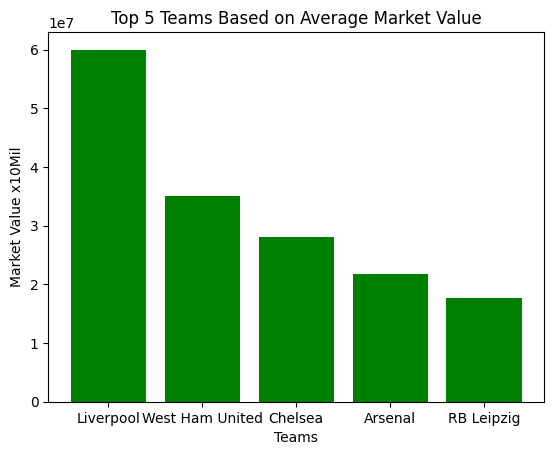

In [30]:
# Create a bar chart.
plt.bar(mean_mv.head(5).index.to_list(), mean_mv.head(5), color="Green")

# Set Title and labels
plt.title("Top 5 Teams Based on Average Market Value")
plt.xlabel("Teams")
plt.ylabel("Market Value x10Mil")

# Show the chart
plt.show()

Next I want to visualize the distribution of Positions between players, it's like the overview I showed earlier but made into a graph to give us a better visualization of the distribution. Here we can see again that CF is the most popular position by far.

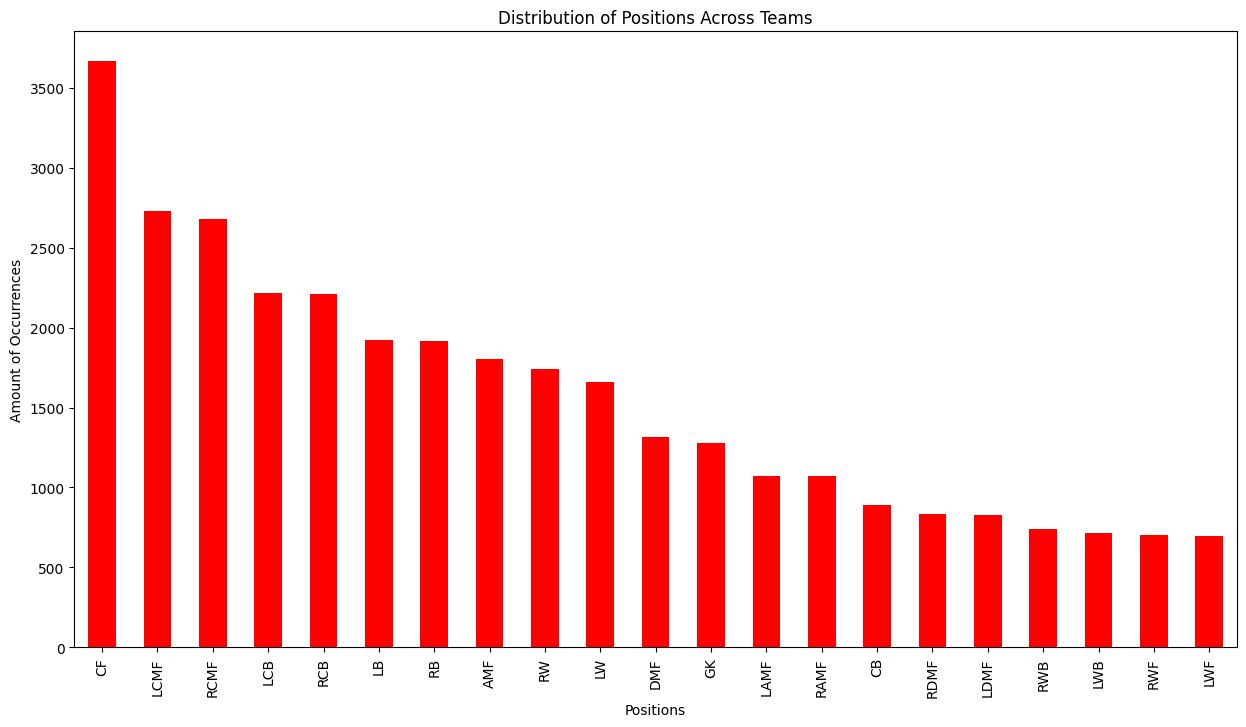

In [32]:
# Set the size of the image
plt.figure(figsize=(15, 8))
# Create bar chart.
df["Position"].value_counts().plot(kind="bar", color="red")
# Set title and labels of histogram.
plt.title("Distribution of Positions Across Teams")
plt.xlabel("Positions")
plt.ylabel("Amount of Occurrences")

plt.show()

For the analysis we did earlier about most occuring countries, I will also make a visualisation. I chose to only visualize the top 5, just so the graph will stay readable and won't overflow you with information. In this visual we can see that the country on first place is Italy, the amount of players from Italy heavily outweigh the other countries. 

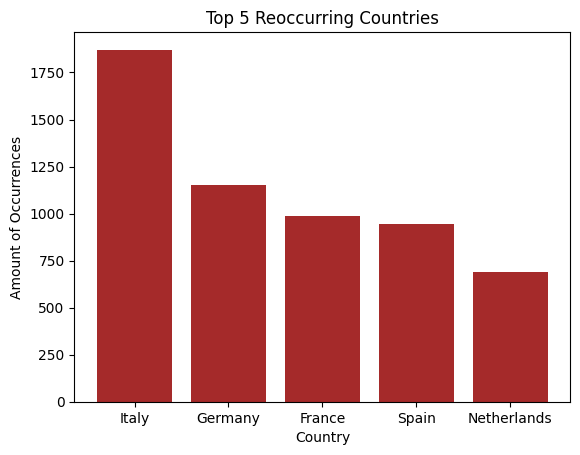

In [33]:
# Set the size of the image
# Create histogram
plt.bar(nacdata["Birth country"].value_counts().head(5).index.to_list(), nacdata["Birth country"].value_counts().head(5), color="brown")
# Set title and labels of histogram.
plt.title("Top 5 Reoccurring Countries")
plt.xlabel("Country")
plt.ylabel("Amount of Occurrences")

plt.show()

Next I want to visualize my analysis about the median goals per position, from this we can better visualize why I got to the conclusion that the more aggressive players have a higher median for goals.

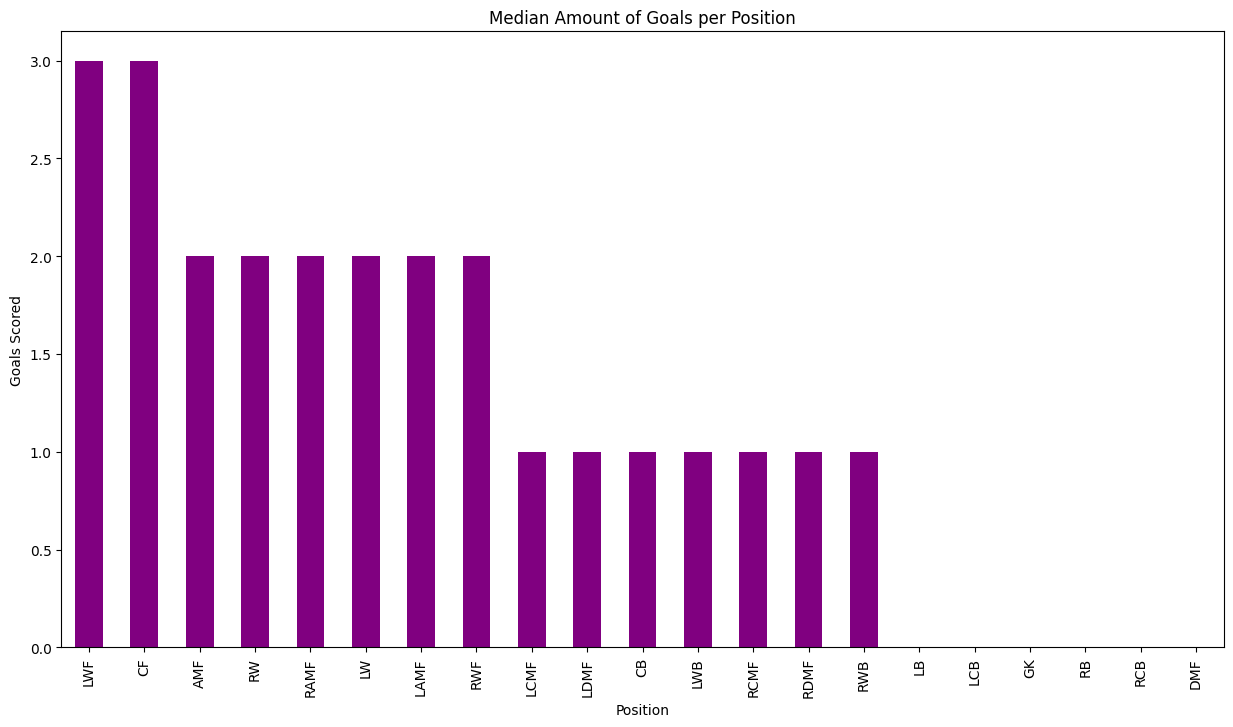

In [36]:
# Set the size of the image
plt.figure(figsize=(15, 8))

# Create bar chart to show the median amount of goals per position.
df.groupby('Position')['Goals'].median().sort_values(ascending=False).plot(kind="bar", color="purple")

# Set title and labels
plt.title("Median Amount of Goals per Position")
plt.xlabel("Position")
plt.ylabel("Goals Scored")

# Show the plot
plt.show()

Next I will visualize the Matches played depending on Age, we can see that the younger a player is, the least matches they play, but this changes after around the age of 23: from this point onwards the line seems to be staying around the same value. There seems to be random peaks of data after the age of 35, but this is due to the lack of players in that age group in the dataset.

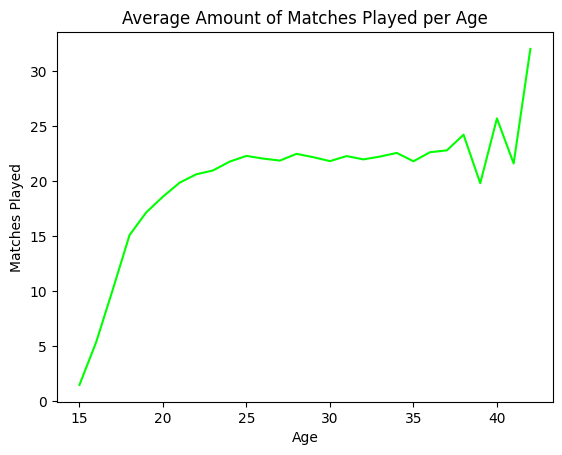

In [37]:
# Create Bar chart which shows the average amount of matches played per age.
nacdata.groupby("Age")["Matches played"].mean().plot(color="lime")

# Set title and label
plt.title("Average Amount of Matches Played per Age")
plt.xlabel("Age")
plt.ylabel("Matches Played")

# Show the plot
plt.show()

Now I will visualize the expected goals with goals per top player, this will visualize the conclusion I made earlier a bit better. This shows that the amount of goals aren't always the same as the amount of expected goals. The visual also shows that the player with the highest amount of expected goals doesn't score the most goals at all.

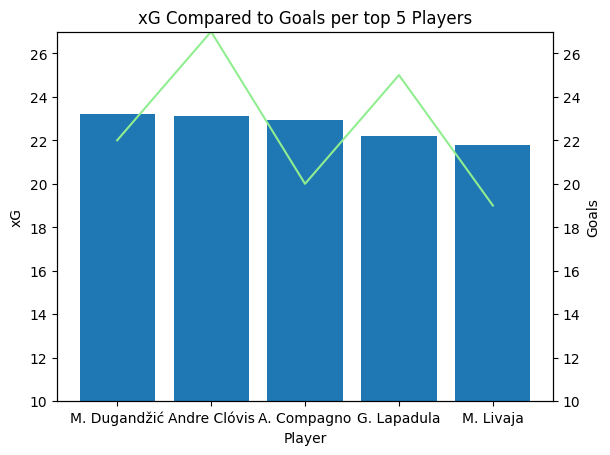

In [38]:
# Get axis and figure variables
fig, ax = plt.subplots()
ax2 = ax.twinx()

# Create variable which will be used for plotting.
players_xG = nacdata.groupby("Player").agg({'xG': 'mean', 'Goals': 'mean'}).nlargest(5, 'xG')

# Create plot to show players with highest xG.
ax.bar(players_xG.index.tolist(), players_xG["xG"])

# Create the bars to show the actual amount of goals.
ax2.plot(players_xG.index.tolist(), players_xG["Goals"], color="lightgreen")

# Set limits
ax.set_ylim(10, 27)
ax2.set_ylim(10, 27)

# Set title and labels
ax.set_title("xG Compared to Goals per top 5 Players")
ax.set_xlabel("Player")
ax.set_ylabel("xG")
ax2.set_ylabel("Goals")

plt.show()

Now I want to visualize the question: How do duels won and aerial duels won vary by position? Looking at the visual, we can keep the conclusion made earlier: the more defensive positions have the higher average amount of duels won and both datapoints have about the same distribution.

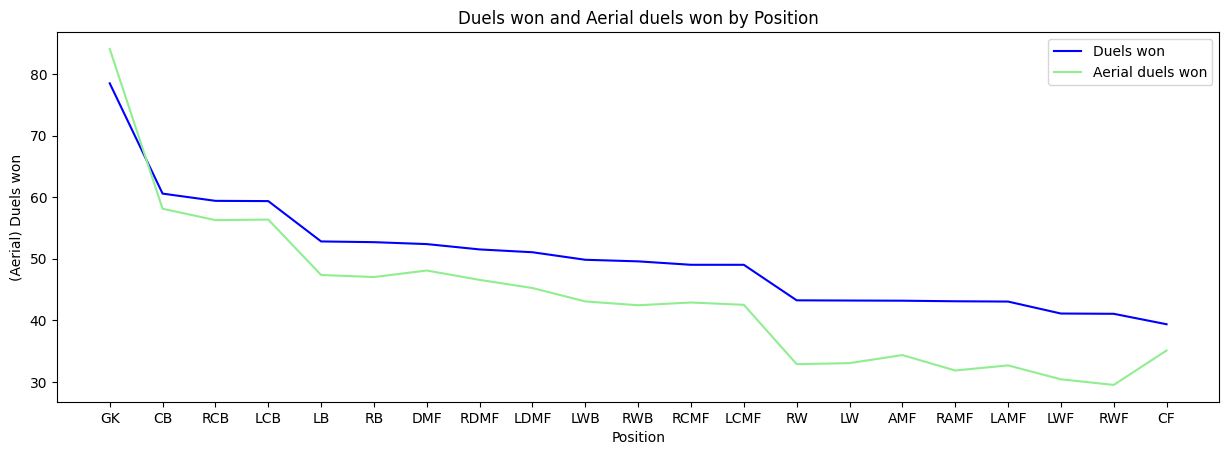

In [39]:
# Create Figure and Axis variables.
fig, ax = plt.subplots()
# Create ax2

# Set the size of the image
fig.set_figwidth(15)

df_duelsperpos = df.groupby("Position").agg({'Duels won, %': 'mean', 'Aerial duels won, %': 'mean'}).sort_values(by="Duels won, %", ascending=False)
# Plot the Average Duels Won per Position.
ax.plot(df_duelsperpos.index.tolist(), df_duelsperpos["Duels won, %"], color="blue", label="Duels won")
ax.plot(df_duelsperpos.index.tolist(), df_duelsperpos["Aerial duels won, %"], color="lightgreen", label="Aerial duels won")

plt.legend()

# Set titles and labels.
ax.set_title("Duels won and Aerial duels won by Position")
ax.set_xlabel("Position")
ax.set_ylabel("(Aerial) Duels won")

# Show plot
plt.show()

*Above visual made me question if this difference in columns per position could effect the models I want to make, which is why I will later try to do some research into the best fitting columns per position.*

Now I will visualize the analysis about if there is a difference between the successful defensive actions for people on loan or permanent. I can now for sure conclude that there is no real significant difference between the two.

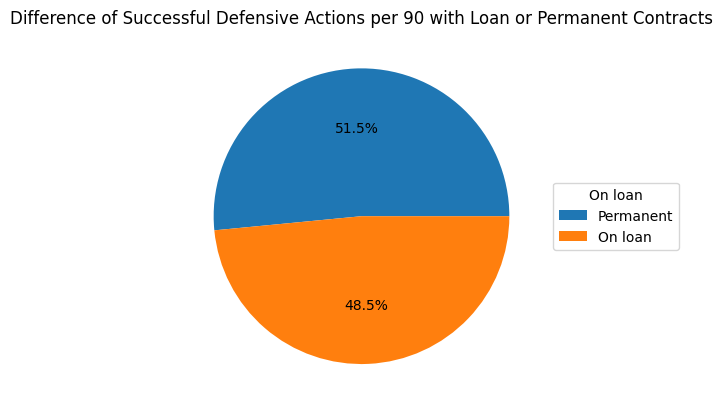

In [40]:
# Create pie chart
plt.pie(nacdata.groupby("On loan")["Successful defensive actions per 90"].mean(), autopct='%1.1f%%',)

# Create a legend for the pie chart
plt.legend(["Permanent", "On loan"],
          title="On loan",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Set the title.
plt.title("Difference of Successful Defensive Actions per 90 with Loan or Permanent Contracts")

# Show plot
plt.show()

When visualizing the analysis about passes with midfielders from earlier, I can see that there is a really slight correlation to the two variables. There has to be a different variable which also has impact on this correlation, but it needs some extra future research.

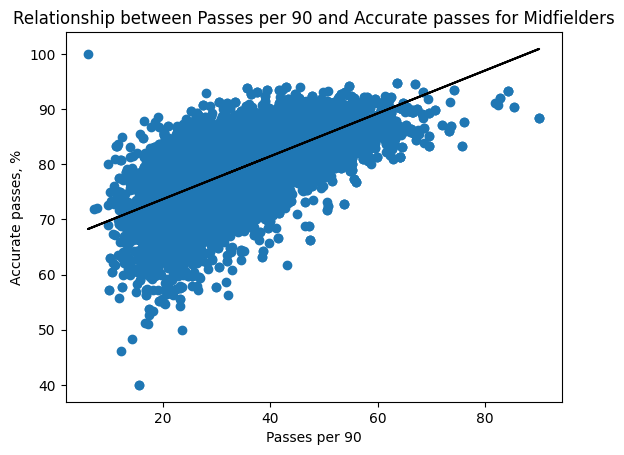

In [42]:
# Create scatter plot for the relationship between Passes per 90 and Assists per 90 for midfielders.
plt.scatter(midfielders["Passes per 90"], midfielders["Accurate passes, %"])

# Create the elements needed for the trend line.
z = np.polyfit(midfielders["Passes per 90"], midfielders["Accurate passes, %"], 1)
p = np.poly1d(z)

# Set title and labels
plt.title("Relationship between Passes per 90 and Accurate passes for Midfielders")
plt.xlabel("Passes per 90")
plt.ylabel("Accurate passes, %")

 # Create the trend line.
plt.plot(midfielders["Passes per 90"], p(midfielders["Passes per 90"]), color="black", linestyle="-")
plt.show()

Now to look at the visual for the distribution between the yellow and red cards per position. We can see here that the three highest amount of yellow cards are in Front and MidFielder positions, but the amounts aren't always this high in front and midfielder positions and can sometimes also be a bit higher in back positions. These amounts could be due to higher amounts of players in these positions or due to certain outliers.

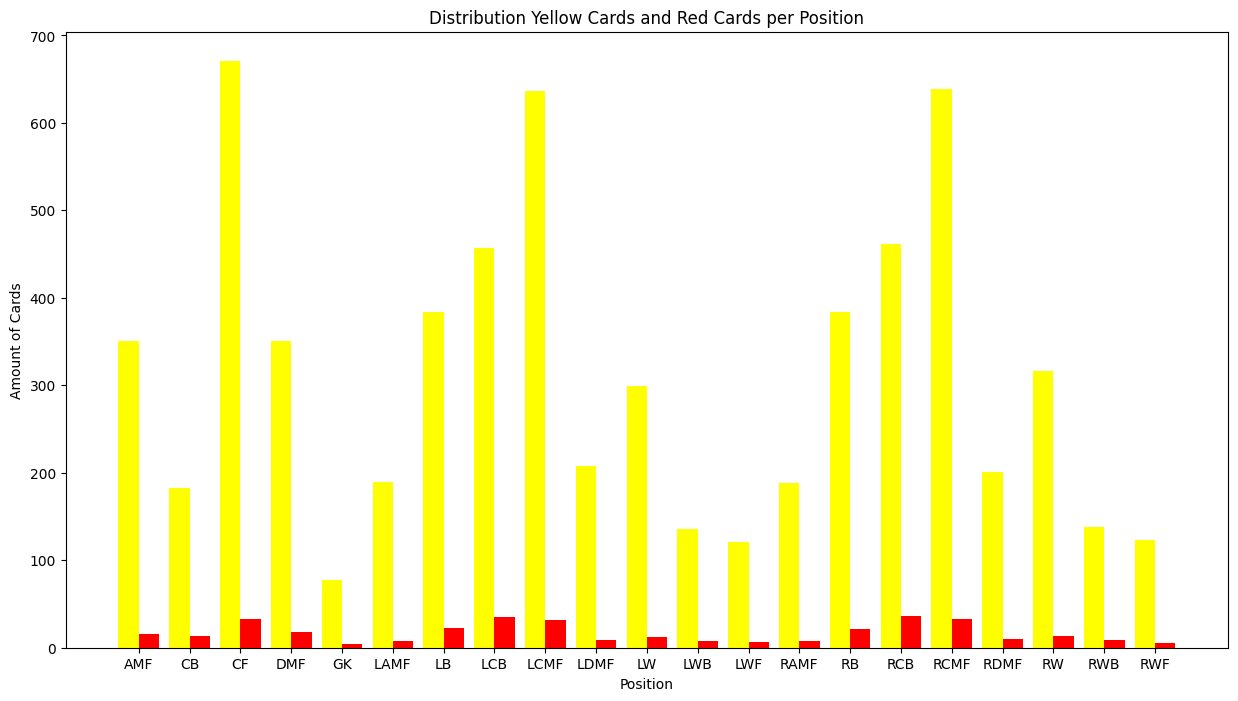

In [44]:
# Set the size of the image
plt.figure(figsize=(15, 8))

# Set the value for x
x = np.arange(len(cards.index.tolist())) 

# Plot the distribution of Yellow cards and Red cards per 90
plt.bar(x - 0.2, cards["Yellow cards per 90"], 0.4, label = 'Yellow', color="yellow") 
plt.bar(x + 0.2, cards["Red cards per 90"], 0.4, label = 'Red', color="Red") 

# Set the value for x-axis
plt.xticks(x, cards.index.tolist()) 
plt.title("Distribution Yellow Cards and Red Cards per Position")
plt.xlabel("Position")
plt.ylabel("Amount of Cards")

plt.show()

Below pie chart visualizes the question about the difference of fouls suffered for attackers and defenders. We can see here that in terms of percentages, attackers have around 30% more fouls than defenders.

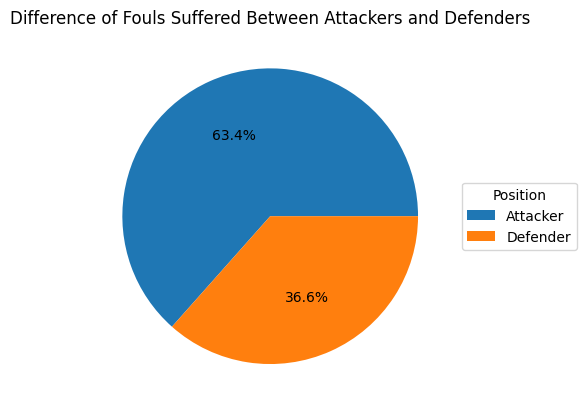

In [45]:
fouls = new_df.groupby("Position").agg({"Fouls suffered per 90": "mean"})

# Create pie chart
plt.pie(fouls["Fouls suffered per 90"], autopct='%1.1f%%',)

# Create a legend for the pie chart
plt.legend(fouls.index.tolist(),
          title="Position",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

# Set the title.
plt.title("Difference of Fouls Suffered Between Attackers and Defenders")

# Show plot
plt.show()

## Machine Learning

### Identifying basic Machine Learning applications.

#### Simple machine learning modelling pipeline

In below code, I first initialize a LabelEncoder for turning categorical columns into binary data, afterwards I will create the X, y and y_lin variables, normal y is used for all models and y_lin is only used for Linear Regression models, this is to make sure the Linear Regression model still predicts the right thing, since y_lin uses Market value, which is continuous. The normal y variable uses the Market Value bins. After this I split up the data into training and testing data for both normal models and Linear Regression models. At the end I will initialize the dataframes for the final models.

In [56]:
# Convert text data into binary data.
label_encoder = LabelEncoder()
categorical_columns = df.select_dtypes(include=['object']).columns
# Make a copy for the dataframe for future use.
saved_df = df
# Go through all categorical columns.
for col in categorical_columns:
    # Turn the categorical data into binary data.
    df[col] = label_encoder.fit_transform(df[col])

# Create X and y variables with related columns.
X = df[["Age", "Minutes played", "Matches played", "Goals", "xG", "On loan", "Yellow cards", "Red cards", "Position Bin", "Successful defensive actions per 90", "Successful attacking actions per 90", "Shots against", "Save rate, %"]]
y = df["Bin"]
# Linear Regression needs different kind of y values, so a secondary is needed
y_lin = df["Market value"]


# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(X, y_lin, test_size=0.3, random_state=42)

# Below code is for the eventual models I want to use.
# Initialise the dataframes
goalkeepers = df.loc[df["Position Bin"] == 2].drop("Position Bin", axis=1)
attackers = df.loc[df["Position Bin"] == 0].drop("Position Bin", axis=1)
defenders = df.loc[df["Position Bin"] == 1].drop("Position Bin", axis=1)
midfielders = df.loc[df["Position Bin"] == 3].drop("Position Bin", axis=1)

Reason behind chosen columns:
- Age: Football clubs mostly prefer younger players
- Minutes played scaled: scaled value of amount of minutes played, more experience can lead to better performance
- Matches played scaled: scaled value of amount of matches played, if a player plays more matches, they have more experience and it could increase their performance.
- Goals scaled: The scaled value of the amount of goals, this value is chosen together with expected goals to show if the player really performs as well as expected. Goals are related and is important to to the Position Group of Attackers.
- xG scaled: The scaled value of the amount of Expeted Goals, this value is chosen together with Goals to show if the player is expected to perform well or not. xG are related and is important to to the Position Group of Attackers.
- On loan: Binary value if player is on loan or not, the loan of a player could impact if the player can be accepted into a team or not.
- Yellow cards scaled: Scaled value of yellow cards in relation to red cards, this value shows if the player plays according to the rules often or not, it could have a slight impact their market value and performance if they have many yellow cards
- Red cards scaled: Scaled value of red cards in relation to yellow cards, this value has the same reasoning as yellow cards behind it, but it has a more heavy weight to it.
- Position Bin: Groups of positions the player is in, it can be either Attacker, Defender, Midfielder or Goalkeeper. This bin would determine which columns are important for them and is needed for the model to understand which columns are actually needed for the role.
- Successful defensive actions per 90: This column is used to determine the performance of the defender.
- Successful attacking actions per 90: This column is used to determine the performance of the attacker.
- Shots against: This column is used to determine the performance of the goalkeeper.
- Save rate, %: This column is used to determine the performance of the goalkeeper.

#### Linear regression

First off, we will train the Linear Regression model. The scores seem to be very low, but I will look further into the performances later on.

In [57]:
# Create the Linear Regression Model
lr = LinearRegression()
# Train the model
lr.fit(X_train_lin, y_train_lin)

# Predict using the test set
y_pred_lin = lr.predict(X_test_lin)

# Calculate and print the score.
print("Score testing data:", lr.score(X_test_lin, y_test_lin))
print("Score training data", lr.score(X_train_lin, y_train_lin))

Score testing data: 0.04626023456830519
Score training data 0.05587548583185742


#### Logistic regression

Next, we will train the Logistic Regression model, which seems to have a much higher score and doesn't underfit nor overfit, this score will increase in our final model and we will evaluate the scores later on.

In [58]:
# Create Logistic Regression Model.
log_reg = LogisticRegression(max_iter=100000)

# Train the model
log_reg.fit(X_train, y_train)

# Make a prediction
y_pred_log = log_reg.predict(X_test)

# Calculate and print the score
print("Score testing data:", log_reg.score(X_test, y_test))
print("Score training data:", log_reg.score(X_train, y_train))

Score testing data: 0.5062684741616553
Score training data: 0.5086493098025511


#### Tree-based model

Next is the Random Forest Classifier, which shows to have a slightly lower score on both testing and training data compared to Logistic Regression. The scores will be evaluated further later on.

In [59]:
# Create the Model
clf = RandomForestClassifier(max_depth=2, min_samples_split=2, n_estimators=50)

# Train model
clf.fit(X_train, y_train)
  
# Predict the result
y_pred_clf = clf.predict(X_test)

# Calculate and print out the score.
print("Score testing data:", clf.score(X_test, y_test))
print("Score training data:", clf.score(X_train, y_train))

Score testing data: 0.49261033533788606
Score training data: 0.49515114450463044


#### Gradient Boosting Trees

Now we will look at Gradient Boosting, which seems to have a much higher score and seems to be the bette model at this moment, but it also overfits the data quite a bit. We will compare the scores later to choose which model is better.

In [60]:
# Initiate the gradient booster classifier
gb = XGBClassifier(max_depth=2, n_estimators=200)

# Train the model.
gb.fit(X_train, y_train)

# Predict the values
y_pred_gb = gb.predict(X_test)

# Print score
print("Score testng data:", gb.score(X_test, y_test))
print("Score training data:", gb.score(X_train, y_train))

Score testng data: 0.5475486698603608
Score training data: 0.5764896033548838


#### Unsupervised learning with K-Means

c:\Users\jason\anaconda3\envs\block_b\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


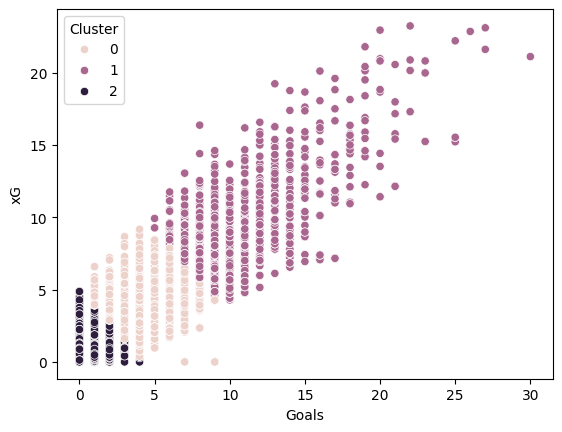

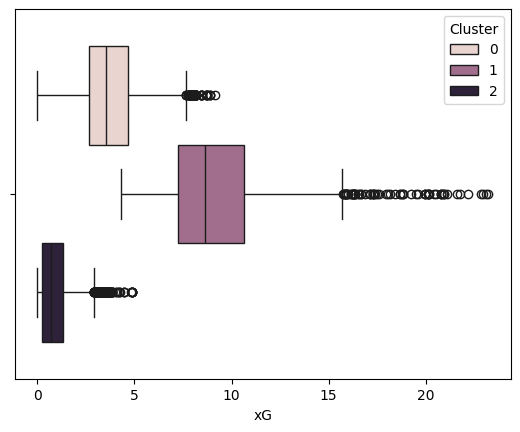

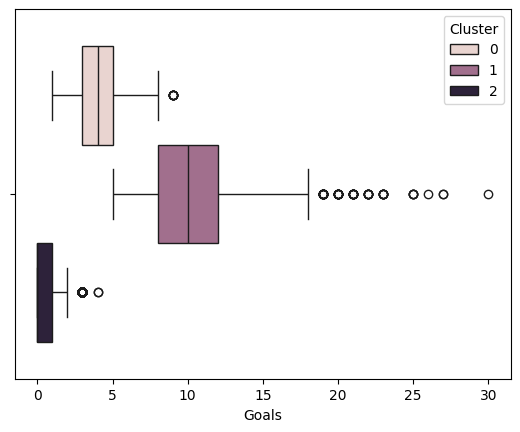

In [61]:
# Initiate the k-means
kmeans = KMeans(n_clusters=3)

# Create the clusters
kmeans.fit(X[["Goals", "xG"]])
# Predict the result
y_pred_kmeans = kmeans.predict(X[["Goals", "xG"]])

# Initiate kmeandata
kmeansdata = pd.DataFrame()

# Add Goals and xG columns
kmeansdata["Goals"] = X["Goals"]
kmeansdata["xG"] = X["xG"]

# Get cluster labels
kmeansdata["Cluster"] = kmeans.labels_

sns.scatterplot(x="Goals", y="xG", hue="Cluster", data=kmeansdata)
plt.show()

sns.boxplot(x="xG", hue="Cluster", data=kmeansdata)
plt.show()

sns.boxplot(x="Goals", hue="Cluster", data=kmeansdata)
plt.show()

If we look at this graph, we can see the following: cluster 0 is a small cluster with many datapoints of players which get up to 5 goals, cluster 2 are somewhere between 5 and 10 and cluster 1 is full of players with more than 10 Goals or xG. Cluster 10is most likely to contain goalkeepers and some defenders or midfielders, Cluster 2 would most likely contain some defenders, many midfielders and some attackers and cluster 1 would most likely contain some midfielders and many attackers. When looking at the boxplots, we can say that the boxes do overlap each other and there are many outliers in every categories. This shows that the clusters don't just contain one position or role, but could contain multiple.

#### Correlation Analysis and Feature Selection


##### Correlation Analysis

First, let's look at the correlations for goalkeepers. As heads up: if a column's correlation is higher than 10 and they also make sense in the current context, I will call it a slight correlation, this is due to the amounts of data which really mess with the correlations in the dataset. Since most of my models focus on Bin, I will mostly focus on their correlations.

In [62]:
# Get all correlations for goalkeepers.
gk_corr = pd.DataFrame(goalkeepers.corr()[["Bin", "Market value"]])

gk_corr.style.background_gradient(cmap='coolwarm')

,Bin,Market value
Unnamed: 0,-0.520982,-0.348568
Player,-0.026411,-0.020166
Team,-0.024300,-0.050572
Team within selected timeframe,-0.024312,-0.058910
Position,nan,nan
Age,0.150149,0.045192
Market value,0.485393,1.000000
Contract expires,0.346805,0.280070
Matches played,0.400275,0.246147
Minutes played,0.406892,0.251751


Here we can see that the following columns have the highest correlations (above 10%):
- Contract expires (Market value: 28%, Bin: 35%)
- Matches played (Market value: 25%, Bin: 40%)
- Minutes played (Market value: 25%, Bin: 40%)
- Height (Market value: 13%, Bin: 30%)
- Weight (Market value: 15%, Bin: 35%)
- Fouls suffered per 90 (Market value: -12%, Bin: 15%)
- Accurate passes, % (Market value: 10%, Bin: 11%)
- Conceded goals (Market value: 12%, Bin: 30%)
- Conceded goals per 90 (Market value: -17%, Bin: 22%)
- Shots against (Market value: 17%, Bin: 33%)
- Shots against per 90 (Market value: -15%, Bin: 21%)
- Clean sheets (Market value: 29%, Bin: 40%)
- Save rate, % (Market value: 10%, Bin: 13%)
- xG against (Market value: 15%, Bin: 33%)
- xG against per 90 (Market value: -15%, Bin: 18%)
- Prevented goals (Market value: 10%, Bin: 11%)
- Prevented goals per 90 (Market value: 8%, Bin: 12%)
  
We can agree that these correlations aren't very high, but these values will be the most useful out of all of them if we scale them, since it would most likely make a higher correlation. It makes sense that these columns have a relationship with goalkeepers, so we can mainly use these columns together with the other important columns

On to the attackers:

For this one I will use the same reasoning as the last: I will choose the correlations above 10 and only if they make sense in the current context, since an attacker wouldn't need a correlation for e.g. xG against, since this would only skew the model.

In [63]:
# Get all correlations for attackers.
at_corr = pd.DataFrame(attackers.corr()[["Bin", "Market value"]])

at_corr.style.background_gradient(cmap='coolwarm')

,Bin,Market value
Unnamed: 0,-0.567917,-0.303747
Player,0.003131,0.009273
Team,-0.033187,-0.054329
Team within selected timeframe,-0.036038,-0.048064
Position,-0.015044,-0.003880
Age,0.229196,0.017736
Market value,0.382545,1.000000
Contract expires,0.369795,0.306644
Matches played,0.268092,0.092547
Minutes played,0.320931,0.142588


Here we can see that the following columns have the highest correlations:
- Age (not for use in Market value, Bin: 23%)
- Contract expires (Market value: 31%, Bin: 37%)
- Matches played (Market value: 9%, Bin: 27%)
- Minutes played (Market value: 14%, Bin: 32%)
- Goals (Market value: 21%, Bin: 27%)
- xG (Market value: 21%, Bin: 30%)
- Assists (Market value: 19%, Bin: 25%)
- xA (Market value: 21%, Bin: 29%)
- Height (Market value: 12%, Bin: 37%)
- Weight (Market value: 14%, Bin: 41%)
- Goals per 90 (Market value: 16%, Bin: 15%)
- Non-penalty goals (Market value: 21%, Bin: 27%)
- xG per 90 (Market value: 17%, Bin: 17%)
- Shots (Market value: 19%, Bin: 32%)
- Shots per 90 (Market value: 15%, Bin: 19%)
- Touches in box per 90 (Market value: 17%, Bin: 19%)
- Received passes per 90 (Market value: 15%, Bin: 23%)
- xA per 90 (Market value: 16%, Bin: 18%)
- Shot assists per 90 (Market value: 15%, Bin: 20%)
- Smart passes per 90 (Market value: 12%, Bin: 20%)
- Key passes per 90 (Market value: 18%, Bin: 21%)
- Deep completions per 90 (Market value: 21%, Bin: 21%)
#
These columns seem to be related to the attackers, none of these columns really make me question why, since the columns are related to the variety of tasks the attackers have in the matches.

Now time to check out the midfielders:

In [64]:
# Get all correlations for midfielders.
mf_corr = pd.DataFrame(midfielders.corr()[["Bin", "Market value"]])

mf_corr.style.background_gradient(cmap='coolwarm')

,Bin,Market value
Unnamed: 0,-0.551466,-0.306285
Player,0.019499,0.007954
Team,-0.061785,-0.043134
Team within selected timeframe,-0.065708,-0.049615
Position,-0.012601,-0.017786
Age,0.197306,0.003520
Market value,0.385801,1.000000
Contract expires,0.369513,0.317484
Matches played,0.244542,0.120313
Minutes played,0.282068,0.161089


Here are the stronger correlations for MidFielders:
- Age (None for Market value, Bin: 20%)
- Contract expires (Market value:32%, Bin: 37%)
- Matches played (Market value:12%, Bin: 24%)
- Minutes played (Market value:16%, Bin: 28%)
- Goals (Market value:22%, Bin: 22%)
- xG (Market value:22%, Bin: 24%)
- Assists (Market value:19%, Bin: 21%)
- xA (Market value: 22%, Bin: 25%)
- Height (Market value: 12%, Bin: 37%)
- Weight (Market value: 40%, Bin: 13%)
- Non-penalty goals (Market value: 22%, Bin: 21%)
- Shots (Market value: 21%, Bin: 27%)
- Received passes per 90 (Market value: 16%, Bin: 24%)
- Passes per 90 (Market value: 12%, Bin: 19%)
- Accurate passes, % (None for Market value, Bin: 18%)
- Accurate forward passes, % (Market value: 11%, Bin: 19%)
- Back passes per 90 (Market value: 13%, Bin: 18%)
- Short / medium passes per 90 (Market value: 13%, Bin: 20%)
- Smart passes per 90 (Market value: 15%, Bin: 17%)
- Accurate passes to final third, % (Market value: 12%, Bin: 21%)
- Accurate progressive passes, % (Market value: 14%, Bin: 21%)
#
I can see that MidFielders are more focussed on passing the ball, which seems to be right when looking at their role in the matches.

Lastly, we will look at the important columns for Defenders: same rules as before apply.

In [128]:
# Get all correlations for defenders.
def_corr = pd.DataFrame(defenders.corr()[["Bin", "Market value"]])

def_corr.style.background_gradient(cmap='coolwarm')

,Bin,Market value
Unnamed: 0,-0.489948,-0.274417
Player,-0.009885,-0.016239
Team,-0.026656,-0.038801
Team within selected timeframe,-0.027234,-0.062958
Position,-0.006865,-0.000004
Age,0.179573,0.006742
Market value,0.376408,1.000000
Contract expires,0.330391,0.249346
Matches played,0.234618,0.108016
Minutes played,0.271214,0.131226


The important columns for defenders are the following:
- Age (None for Market value, Bin: 18%)
- Contract expires: (Market value: 25%, Bin: 33%)
- Matches played (Market value: 11%, Bin: 23%)
- Minutes played (Market value: 13%, Bin: 27%)
- xG (Market value: 17%, Bin: 21%)
- Height (Market value: 12%, Bin: 35%)
- Weight (Market value: 13%, Bin: 38%)
- Shots (Market value: 16%, Bin: 22%)
- Received passes per 90 (Market value: 20%, Bin: 22%)
- Passes per 90 (Market value: 18%, Bin: 20%)
- Accurate forward passes, % (Market value: 13%, Bin: 19%)
- Short / medium passes per 90 (Market value: 19%, Bin: 20%)
- Accurate passes to final third, % (Market value: 18%, Bin: 13%)
- Accurate progressive passes, % (Market value: 13%, Bin: 20%)

Here we finally see that the defenders have the same kinds of correlations as midfielders seem to have, so I would want to group them together.

These were the best-fitted columns per role in the football team, Defenders and MidFielders could have the same models, since they have almost the same columns to use. This leaves us with 3 kinds of models: Attackers, Goalkeepers and Defenders (MidFielders + Defenders).

Feature Selection

In [65]:
# Select features for goalkeepers:
goalkeepers = goalkeepers[["Market value", "Bin", "Contract expires", "Matches played", "Minutes played", "Height", "Weight", "Fouls suffered per 90", "Accurate passes, %", "Conceded goals", "Conceded goals per 90", "Shots against", "Shots against per 90", "Clean sheets", "Save rate, %"]]

# Select the features for attackers:
attackers = attackers[["Market value", "Bin", "Contract expires", "Matches played", "Minutes played", "Goals", "xG", "Assists", "xA", "Height", "Weight", "Goals per 90", "Non-penalty goals", "xG per 90", "Shots", "Shots per 90", "Touches in box per 90", "Received passes per 90", "xA per 90", "Shot assists per 90", "Smart passes per 90", "Key passes per 90", "Deep completions per 90"]]

# Select features for MidFielders and Defenders
mid_def_cols = ["Market value", "Bin", "Age", "Contract expires", "Matches played", "Minutes played", "Goals", "xG", "Assists", "xA", "Height", "Weight", "Non-penalty goals", "Shots", "Received passes per 90", "Passes per 90", "Accurate passes, %", "Accurate forward passes, %", "Back passes per 90", "Short / medium passes per 90", "Accurate passes to final third, %", "Accurate progressive passes, %"]
# Add MidFielders and Defenders into one dataframe.
mid_def = df.loc[(df["Position Bin"] == 3) | (df["Position Bin"] == 1)].drop("Position Bin", axis=1)[mid_def_cols]

# Drop the duplicate values in attackers and midfielders/defenders.
attackers = attackers.drop_duplicates()
mid_def = mid_def.drop_duplicates()

✍️ I chose the features above because they all have the strongest correlations with Market value and the Bin columns, I mixed MidFielders and Defenders together because they have many of the same correlations between colums. All the columns in the separate DataFrames are related to the role they have been assigned to because of the correlation analysis from earlier. The columns will be scaled together to create stronger correlations between these values. Lastly I dropped all duplicate values in attackers and midfielders and defenders, since these could contain a player multiple times due to multiple positions (Unlike goalkeeper).

### Evaluating the performance of the model

In the following subsection include your Python code on how you evaluated your chosen model(s). This is related to the sufficient criteria of ILO 5.0. 

Linear Regression

In [66]:
# Calculate the Linear Regression scores.
mse = mean_squared_error(y_test_lin, y_pred_lin)
rmse = mse ** 0.5
r2 = r2_score(y_test_lin, y_pred_lin)

# Print out the Linear Regression scores.
print("Score testing data:", lr.score(X_test_lin, y_test_lin))
print("Score training data:", lr.score(X_train_lin, y_train_lin))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print(cross_val_score(lr, X, y))

Score testing data: 0.04626023456830519
Score training data: 0.05587548583185742
Mean Squared Error: 1588354751113.794
Root Mean Squared Error: 1260299.4688223088
R-Square: 0.04626023456830519
[0.05256356 0.04590991 0.05634342 0.02373568 0.13647904]


These scores for Linear Regression don't seem to be that good, so I doubt this model would be very useful with this context.

Logistic Regression

In [67]:
# Calculate the Logistic Regression scores
mse = mean_squared_error(y_test, y_pred_log)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_log)
accuracy = accuracy_score(y_test, y_pred_log)

# Print out the scores.
print("Score testing data:", log_reg.score(X_test, y_test))
print("Score training data:", log_reg.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_log))
print("Cross Validation Score:", cross_val_score(log_reg, X, y))
print(confusion_matrix(y_test, y_pred_log))

Score testing data: 0.5062684741616553
Score training data: 0.5086493098025511
Mean Squared Error: 0.7930893894608093
Root Mean Squared Error: 0.8905556633140959
R-Square: -0.30032853231084955
Accuracy Score: 0.5062684741616553
              precision    recall  f1-score   support

           0       0.55      0.66      0.60      3656
           1       0.48      0.54      0.51      3684
           2       0.45      0.23      0.30      2471

    accuracy                           0.51      9811
   macro avg       0.49      0.48      0.47      9811
weighted avg       0.50      0.51      0.49      9811



Cross Validation Score: [0.52056261 0.50175814 0.51949243 0.49923547 0.47568807]
[[2400  987  269]
 [1266 2000  418]
 [ 710 1194  567]]


Random Forest Classifier

In [68]:
# Calculating the scores
mse = mean_squared_error(y_test, y_pred_clf)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_clf)
accuracy = accuracy_score(y_test, y_pred_clf)
  
# Print out the RandomForestClassifier scores
print("Score testing data:", clf.score(X_test, y_test))
print("Score training data:", clf.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_clf, zero_division=0))
print("Cross Validation Score:", cross_val_score(clf, X, y))
print(confusion_matrix(y_test, y_pred_clf))

Score testing data: 0.49261033533788606
Score training data: 0.49515114450463044
Mean Squared Error: 0.6957496687391703
Root Mean Squared Error: 0.8341161002757173
R-Square: -0.14073288286259578
Accuracy Score: 0.49261033533788606
              precision    recall  f1-score   support

           0       0.57      0.61      0.59      3656
           1       0.44      0.70      0.54      3684
           2       0.54      0.00      0.01      2471

    accuracy                           0.49      9811
   macro avg       0.52      0.44      0.38      9811
weighted avg       0.51      0.49      0.42      9811



Cross Validation Score: [0.50236967 0.49304388 0.5037456  0.46987768 0.46207951]
[[2237 1418    1]
 [1090 2589    5]
 [ 615 1849    7]]


Gradient Boosting Trees

In [69]:
# Calculate scores.
mse = mean_squared_error(y_test, y_pred_gb)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

# Print out the performances of the model.
print("Score testing data:", gb.score(X_test, y_test))
print("Score training data:", gb.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_gb))
print("Cross Validation Score:", cross_val_score(gb, X, y))
print(confusion_matrix(y_test, y_pred_gb))

Score testing data: 0.5475486698603608
Score training data: 0.5764896033548838
Mean Squared Error: 0.6429517888084803
Root Mean Squared Error: 0.8018427456855117
R-Square: -0.054166865674956766
Accuracy Score: 0.5475486698603608
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      3656
           1       0.49      0.67      0.56      3684
           2       0.54      0.29      0.37      2471

    accuracy                           0.55      9811
   macro avg       0.56      0.52      0.52      9811
weighted avg       0.56      0.55      0.54      9811



Cross Validation Score: [0.53371044 0.51857514 0.55541966 0.49266055 0.48180428]
[[2188 1317  151]
 [ 748 2476  460]
 [ 472 1291  708]]


✍️ Interpretation of the model evaluation: At this moment I would say that Gradient Boosting Trees is te best model for the entire dataset: it has the highest accuracy and generally has the highest precision, recall, f1-score and cross-validation score and it also has the lowest MSE and RMSE. Gradient Boosting also has a much faster run-time than Logistic Regression, which also has a great impact on this decision. This means that this model is most likely more fitted for this dataset, but I want to try to split up the dataset into smaller groups and see what the better model is then. Gradient Boosting does seem to overfit a lot, which is why I should improve the performances after this.

### Improving the performance of the model

In the following subsection include your Python code on how you improved your chosen model(s). This is related to the good criteria of ILO 5.0.  

Scale the data.

In [70]:
# Create Scalers
scaler = StandardScaler()
robust = RobustScaler()
min_max = MinMaxScaler()
abs_scaler = MaxAbsScaler()

Goalkeepers:

First I want to check the correlations between all the columns:

In [71]:
# Show correlations for all columns in goalkeepers dataframe
goalkeepers.corr().style.background_gradient(cmap='coolwarm')

,Market value,Bin,Contract expires,Matches played,Minutes played,Height,Weight,Fouls suffered per 90,"Accurate passes, %",Conceded goals,Conceded goals per 90,Shots against,Shots against per 90,Clean sheets,"Save rate, %"
Market value,1.000000,0.485393,0.280070,0.246147,0.251751,0.129378,0.149024,-0.123180,0.106741,0.129953,-0.171538,0.166334,-0.159537,0.294595,0.100221
Bin,0.485393,1.000000,0.346805,0.400275,0.406892,0.295114,0.349269,-0.152968,0.111112,0.299508,-0.224811,0.328260,-0.208320,0.399464,0.125144
Contract expires,0.280070,0.346805,1.000000,0.179100,0.182446,0.089198,0.085999,-0.089809,0.086586,0.113345,-0.111213,0.132504,-0.112987,0.183654,0.050338
Matches played,0.246147,0.400275,0.179100,1.000000,0.999226,0.152478,0.196590,-0.041415,0.050813,0.852166,-0.295991,0.923829,-0.138688,0.819337,0.314804
Minutes played,0.251751,0.406892,0.182446,0.999226,1.000000,0.155224,0.198708,-0.045639,0.050283,0.851170,-0.298169,0.922518,-0.143468,0.821155,0.313155
Height,0.129378,0.295114,0.089198,0.152478,0.155224,1.000000,0.793160,-0.047228,0.025066,0.098577,-0.141205,0.118787,-0.118062,0.137625,0.095337
Weight,0.149024,0.349269,0.085999,0.196590,0.198708,0.793160,1.000000,-0.086972,0.048135,0.136675,-0.161444,0.156020,-0.152262,0.178766,0.083164
Fouls suffered per 90,-0.123180,-0.152968,-0.089809,-0.041415,-0.045639,-0.047228,-0.086972,1.000000,-0.069450,-0.036837,0.030372,-0.029253,0.045259,-0.048313,-0.041529
"Accurate passes, %",0.106741,0.111112,0.086586,0.050813,0.050283,0.025066,0.048135,-0.069450,1.000000,-0.013171,-0.106251,-0.009762,-0.159998,0.075373,-0.020990
Conceded goals,0.129953,0.299508,0.113345,0.852166,0.851170,0.098577,0.136675,-0.036837,-0.013171,1.000000,0.103868,0.948590,0.187983,0.462489,0.059063


Columns I will scale together based on correlation:
- Minutes played and Matches played
- Conceded goals and Shots against
- Conceded goals per 90 and Shots against per 90

These all seem to have a high correlation with each other, so scaling them together could help increase the performance. Height and Weight won't be used, these only have a correlation in combination with other performance data, so should be used separately.

In [72]:
# Calculate Standardization of Matches and Minutes played
goalkeepers[["Minutes played", "Matches played"]] = scaler.fit_transform(goalkeepers[["Matches played", "Minutes played"]])

# Calculate the scales for Conceded Goals and Shots against
goalkeepers[["Conceded goals", "shots against"]] = robust.fit_transform(goalkeepers[["Conceded goals", "Shots against"]])

# Calculate scales for conceded goals per 90 and shots against per 90
goalkeepers[["Conceded goals per 90", "Shots against per 90"]] = min_max.fit_transform(goalkeepers[["Conceded goals per 90", "Shots against per 90"]])

# split the data
gk_X = goalkeepers.drop(["Market value", "Bin"], axis=1)
gk_y = goalkeepers["Bin"]
# y value for Linear Regression.
gk_y_lin = goalkeepers["Market value"]

Attackers:

First I will look at the correlations of the columns again:

In [73]:
# Show correlations for all columns in goalkeepers dataframe
attackers.corr().style.background_gradient(cmap='coolwarm')

,Market value,Bin,Contract expires,Matches played,Minutes played,Goals,xG,Assists,xA,Height,Weight,Goals per 90,Non-penalty goals,xG per 90,Shots,Shots per 90,Touches in box per 90,Received passes per 90,xA per 90,Shot assists per 90,Smart passes per 90,Key passes per 90,Deep completions per 90
Market value,1.000000,0.372818,0.312464,0.089086,0.139652,0.211853,0.203589,0.203478,0.204146,0.119952,0.139238,0.160859,0.103088,0.161858,0.190146,0.150992,0.181620,0.125257,0.167710,0.157743,0.119608,0.182076,0.202812
Bin,0.372818,1.000000,0.375802,0.271376,0.320970,0.279840,0.304708,0.253135,0.289079,0.372500,0.413473,0.150008,0.226966,0.174596,0.328198,0.195828,0.177551,0.206083,0.172716,0.194394,0.197304,0.200511,0.212367
Contract expires,0.312464,0.375802,1.000000,0.059958,0.100616,0.140426,0.137223,0.102009,0.104543,0.133754,0.145009,0.112083,0.103708,0.127124,0.139079,0.132377,0.145909,0.049561,0.075046,0.063658,0.063405,0.100688,0.114901
Matches played,0.089086,0.271376,0.059958,1.000000,0.865626,0.546970,0.587576,0.463566,0.539093,0.182733,0.188609,0.147596,0.482658,0.104821,0.693514,0.135908,0.090785,0.059503,0.111275,0.128055,0.108661,0.121366,0.076481
Minutes played,0.139652,0.320970,0.100616,0.865626,1.000000,0.673994,0.709176,0.557688,0.657731,0.176292,0.186563,0.193551,0.526220,0.131347,0.820120,0.153291,0.089460,0.119729,0.145408,0.166714,0.160038,0.148201,0.120988
Goals,0.211853,0.279840,0.140426,0.546970,0.673994,1.000000,0.897928,0.425201,0.440750,0.136303,0.164964,0.703596,0.573379,0.549062,0.816706,0.442979,0.369799,-0.048840,0.092902,0.078946,0.128884,0.115733,0.155315
xG,0.203589,0.304708,0.137223,0.587576,0.709176,0.897928,1.000000,0.417959,0.421455,0.178861,0.211633,0.549356,0.515308,0.656349,0.877330,0.505630,0.449794,-0.112156,0.059345,0.049091,0.105023,0.098658,0.139199
Assists,0.203478,0.253135,0.102009,0.463566,0.557688,0.425201,0.417959,1.000000,0.773599,0.100580,0.110815,0.149468,0.321887,0.097213,0.534364,0.181263,0.153521,0.265286,0.501217,0.456727,0.318737,0.459724,0.354835
xA,0.204146,0.289079,0.104543,0.539093,0.657731,0.440750,0.421455,0.773599,1.000000,0.115846,0.112778,0.124538,0.367078,0.041361,0.600852,0.183539,0.127034,0.380375,0.692108,0.640256,0.377975,0.523447,0.429273
Height,0.119952,0.372500,0.133754,0.182733,0.176292,0.136303,0.178861,0.100580,0.115846,1.000000,0.801558,0.089817,0.141006,0.151592,0.181096,0.160723,0.141438,0.064692,0.079042,0.108626,0.094987,0.107543,0.098068


Some important correlations:
- Matches played and Minutes played
- Goals, xG, Shots and Non-penalty goals
- Assists and xA
- Shots per 90 and xG per 90

These datapoints will be scaled together too, since I expect them to have higher correlations with each other then, thus increasing the performances.

In [74]:
# Calculate Standardization of Matches and Minutes played
attackers[["Minutes played", "Matches played"]] = scaler.fit_transform(attackers[["Matches played", "Minutes played"]])

# Calculate the robust scale of Goals, Assists and Shots per 90/xG per 90
attackers[["Goals", "xG", "Shots", "Non-penalty goals"]] = robust.fit_transform(attackers[["Goals", "xG", "Shots", "Non-penalty goals"]])
attackers[["Assists", "xA"]] = robust.fit_transform(attackers[["Assists", "xA"]])
attackers[["Shots per 90", "xG per 90"]] = robust.fit_transform(attackers[["Shots per 90", "xG per 90"]])

# Split the data into X, y and y for Linear Regression.
att_X = attackers.drop(["Market value", "Bin"], axis=1)
att_y = attackers["Bin"]
att_y_lin = attackers["Market value"]

Defenders and Midfielders:

We will first look at all the correlations again.

In [75]:
# Show correlations for all columns in goalkeepers dataframe
mid_def.corr().style.background_gradient(cmap='coolwarm')

,Market value,Bin,Age,Contract expires,Matches played,Minutes played,Goals,xG,Assists,xA,Height,Weight,Non-penalty goals,Shots,Received passes per 90,Passes per 90,"Accurate passes, %","Accurate forward passes, %",Back passes per 90,Short / medium passes per 90,"Accurate passes to final third, %","Accurate progressive passes, %"
Market value,1.000000,0.381022,0.004059,0.296088,0.111956,0.137036,0.189235,0.193883,0.170730,0.177988,0.119174,0.128867,0.157061,0.184213,0.148504,0.116294,0.094560,0.101550,0.109705,0.131286,0.123943,0.137270
Bin,0.381022,1.000000,0.196094,0.354195,0.256104,0.282956,0.199018,0.228567,0.193725,0.227376,0.364586,0.394988,0.192011,0.248097,0.211798,0.169604,0.161617,0.171045,0.134680,0.183557,0.199179,0.209736
Age,0.004059,0.196094,1.000000,-0.137757,0.164463,0.202064,0.051473,0.081999,0.071904,0.096440,0.355556,0.379511,0.038030,0.068376,0.149873,0.164749,0.119757,0.140702,-0.032452,0.140572,0.073801,0.153980
Contract expires,0.296088,0.354195,-0.137757,1.000000,0.058174,0.076958,0.115486,0.111756,0.095681,0.099221,0.110991,0.114275,0.110038,0.116582,0.108717,0.077412,0.082931,0.070607,0.101685,0.093588,0.099417,0.085371
Matches played,0.111956,0.256104,0.164463,0.058174,1.000000,0.891556,0.411464,0.475354,0.394526,0.469007,0.152582,0.148097,0.411432,0.561726,0.029943,0.038214,-0.002477,0.015011,0.069674,0.027430,0.087492,0.123065
Minutes played,0.137036,0.282956,0.202064,0.076958,0.891556,1.000000,0.371149,0.431284,0.371511,0.438914,0.161838,0.172497,0.355490,0.499948,0.159853,0.197265,0.127490,0.140358,-0.032124,0.167663,0.087917,0.116096
Goals,0.189235,0.199018,0.051473,0.115486,0.411464,0.371149,1.000000,0.867367,0.462747,0.513803,0.057927,0.051220,0.822047,0.790333,-0.104952,-0.171859,-0.128311,-0.107980,0.167811,-0.144616,0.056143,0.166452
xG,0.193883,0.228567,0.081999,0.111756,0.475354,0.431284,0.867367,1.000000,0.476173,0.531058,0.086130,0.078467,0.703802,0.874086,-0.135051,-0.203744,-0.139400,-0.120764,0.151890,-0.169798,0.055183,0.167727
Assists,0.170730,0.193725,0.071904,0.095681,0.394526,0.371511,0.462747,0.476173,1.000000,0.789274,0.049550,0.036537,0.402023,0.562508,0.028373,-0.029707,-0.165312,-0.091902,0.277068,-0.050834,0.068120,0.234857
xA,0.177988,0.227376,0.096440,0.099221,0.469007,0.438914,0.513803,0.531058,0.789274,1.000000,0.065004,0.041667,0.456337,0.656878,0.027190,-0.041850,-0.221725,-0.120091,0.338538,-0.077697,0.078119,0.292201


Important correlations:
- Matches played and Minutes played
- Goals, xG and Non-penalty goals
- Assists and xA
- Passes per 90, Received passes per 90 and Short / medium passes per 90
- Accurate passes, % and Accurate forwards passes, %

These columns will also be scaled together in the hope for a higher performance.

In [76]:
# Calculate Standardization of Minutes and Matches played
mid_def[["Minutes played", "Matches played"]] = scaler.fit_transform(mid_def[["Matches played", "Minutes played"]])

# Calculate the robust scale of Goals, xG and Non-penalty goal
mid_def[["Goals", "xG", "Non-penalty goals"]] = robust.fit_transform(mid_def[["Goals", "xG", "Non-penalty goals"]])
# Calculate robust scale of Assists and xA
mid_def[["Assists", "xA"]] = robust.fit_transform(mid_def[["Assists", "xA"]])

# Calculate MinMax scale for Passes per 90, Received passes per 90 and Short / medium passes per 90
mid_def[["Passes per 90", "Received passes per 90", "Short / medium passes per 90"]] = min_max.fit_transform(mid_def[["Passes per 90", "Received passes per 90", "Short / medium passes per 90"]])

# Calculate Max Abs Scale for Accurate passes, % and Accurate forward passes, %
mid_def[["Accurate passes, %", "Accurate forward passes, %"]] = abs_scaler.fit_transform(mid_def[["Accurate passes, %", "Accurate forward passes, %"]])

# Save the X and y values
mid_def_X = mid_def.drop(["Market value", "Bin"], axis=1)
mid_def_y = mid_def["Bin"]
# Save the y value for Linear Regression.
mid_def_y_lin = mid_def["Market value"]

Why I chose what scaler for each dataset:
1. Standardization scaler is used for Matches played and Minutes played, since these two have a relationship and both have a (close to) normal distribution.
2. Goals and xG and many other columns are part of the Robust scaling, since these have many outliers. Aside from that, Goals and xG have a relationship and this makes it easier to compare the two while also working around the outliers.
3. Min-Max scale is used on Weight and Height and is also used on Passes per 90, Received passes per 90 and Short / medium passes per 90, this is because these have a specific range of values with few outliers.
4. Max Abs Scaling is used on Goals per 90 scaled, since the value of this column are almost always around 0, which makes it easier to use after using this scaler.

#### HyperParameter Selection

For HyperParameter selection I wil use both searches on both models to make sure I can really find the best fitted one for each model of each dataset. This seems like a lot of work, but it has been done in the hope for finding the ultimately best model for each set.

##### RandomForest parameter selection.

Initialize Model

In [77]:
# Initialize model
rfc = RandomForestClassifier(random_state=42)

Goalkeeper, GridSearch

In [78]:
# Define grid of parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, None],
    'min_samples_split': [2, 4, 6]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

# Train GridSearchCV
grid_search.fit(gk_X, gk_y)

# Print out best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best score found:  0.56796875


Goalkeeper, RandomizedSearch

In [79]:
# Define the parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 200),
    'max_depth': [2, 4, 6, None],
    'min_samples_split': np.arange(2, 7)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(gk_X, gk_y)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 91, 'min_samples_split': 2, 'max_depth': None}
Best score found:  0.5703125


Comparing the two answeres for Goalkeeper's parameter searches for RandomForestClassifier, we see that the highest score is 57% with 91 estimators, 2 min samples splits and no max depth.

Attacker, GridSearch

In [80]:
# Define grid of parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, None],
    'min_samples_split': [2, 4, 6]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

# Train GridSearchCV
grid_search.fit(att_X, att_y)

# Print out best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 200}
Best score found:  0.560679195143154


Attacker RandomizedSearch

In [81]:
# Define the parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 200),
    'max_depth': [2, 4, 6, None],
    'min_samples_split': np.arange(2, 7)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(att_X, att_y)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 92, 'min_samples_split': 4, 'max_depth': 6}
Best score found:  0.5620245810687605


Theres no strong difference between the RandomForestClassifier scores of RandomSearch and GridSearch, RandomSearch has the slightly higher score of 56,2% with 92 estimators, 4 min samples splits and a max depth of 6.

Defender and Midfielder GridSearch

In [82]:
# Define grid of parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, None],
    'min_samples_split': [2, 4, 6]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, n_jobs=-1)

# Train GridSearchCV
grid_search.fit(mid_def_X, mid_def_y)

# Print out best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 6, 'min_samples_split': 6, 'n_estimators': 200}
Best score found:  0.5905382126194264


Defender and Midfielder RandomSearch

In [83]:
# Define the parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 200),
    'max_depth': [2, 4, 6, None],
    'min_samples_split': np.arange(2, 7)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(mid_def_X, mid_def_y)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 101, 'min_samples_split': 5, 'max_depth': 6}
Best score found:  0.5900677473655083


If we compare the GridSearch and RandomSearch on the RandomTreeClassifier of Defenders and Midfielders, we can see that the score of GridSearch has slightly higher score, the GridSearch advices 200 estimators, 6 min samples splits and a max depth of 6, so I will use those for the RandomTreeClassifier.

##### GradientBoosting parameter selection.

Initialize Model

In [84]:
# Initialize model
gbc = XGBClassifier(random_state=42)

Goalkeeper GridSearch

In [85]:
# Define grid of parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, n_jobs=-1)

# Train GridSearchCV
grid_search.fit(gk_X, gk_y)

# Print out best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 2, 'n_estimators': 100}
Best score found:  0.5453125


Goalkeeper RandomSearch

In [86]:
# Define the parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 200),
    'max_depth': [2, 4, 6, None]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbc, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(gk_X, gk_y)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 105, 'max_depth': 2}
Best score found:  0.54765625


The RandomSearch for the usage of the GradientBoost model on goalkeepers had the higher score compared to the GridSearch. It suggests us to use 105 estimators and a max depth of 2.

Attacker GridSearch

In [87]:
# Define grid of parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, n_jobs=-1)

# Train GridSearchCV
grid_search.fit(att_X, att_y)

# Print out best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 2, 'n_estimators': 50}
Best score found:  0.5588334240340375


Attacker RandomSearch

In [88]:
# Define the parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 200),
    'max_depth': [2, 4, 6, None]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbc, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(att_X, att_y)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 60, 'max_depth': 2}
Best score found:  0.5598419687471288


The RandomSearch scores slightly higher than the GridSearch for the GradientBooster on attacker positions, it suggests that we should use 60 estimators and a max depth of 2.

Defender and Midfielder GridSearch

In [89]:
# Define grid of parameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [2, 4, 6, None]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=gbc, param_grid=param_grid, cv=5, n_jobs=-1)

# Train GridSearchCV
grid_search.fit(mid_def_X, mid_def_y)

# Print out best parameters and scores
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)

Best parameters found:  {'max_depth': 2, 'n_estimators': 100}
Best score found:  0.5946952290912446


Defender and Midfielder RandomSearch

In [90]:
# Define the parameter distribution
param_dist = {
    'n_estimators': np.arange(50, 200),
    'max_depth': [2, 4, 6, None]
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=gbc, param_distributions=param_dist, n_iter=100, cv=5, n_jobs=-1, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(mid_def_X, mid_def_y)

# Best parameters and score
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)

Best parameters found:  {'n_estimators': 52, 'max_depth': 2}
Best score found:  0.5950869555191736


For the Defender and Midfielder players the scores are very close. The RandomSearch has a higher score so I would like to follow what that model suggests. RandomSearch suggests us to use 52 estimators and a max depth of 2 when using the Midfielder and Defenders for predictions.

✍️ I improved my model by first analysing which columns have the strongest correlations and connecting them together with some other columns. I used those columns to scale them together to make sure these columns can make better predictions, by reducing the amounts of outliers. Afterwards I ran GridSearch and RandomSearch models for both the RandomForestClassifier and GradientBoostClassifier to see which parameters would be best fitted for these two models. I did this per position, because the models may vary depending on which position you use. I can use the parameters which these searches gave back to improve the performance of my models.

### Choose the best model

In the following subsection reflect on the most appropriate machine learning model. This is related to the excellent criteria of ILO 5.0.  

For deciding the best model, I wil first check the models for goalkeepers, then for attackers and lastly for defenders and midfielders.

#### Goalkeepers

#### Pipeline

In [91]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(gk_X, gk_y, test_size=0.3, random_state=42)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(gk_X, gk_y_lin, test_size=0.3, random_state=42)

#### Linear Regression

In [92]:
# Create the Linear Regression Model
lr = LinearRegression()
# Train the model
lr.fit(X_train_lin, y_train_lin)

# Predict using the test set
y_pred_lin = lr.predict(X_test_lin)

# Calculate the Linear Regression scores.
mse = mean_squared_error(y_test_lin, y_pred_lin)
rmse = mse ** 0.5
r2 = r2_score(y_test_lin, y_pred_lin)

# Print out the Linear Regression scores.
print("Score testing data:", lr.score(X_test_lin, y_test_lin))
print("Score training data:", lr.score(X_train_lin, y_train_lin))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Cross Validation Score:", cross_val_score(lr, X, y))

Score testing data: 0.19894303780572276
Score training data: 0.15032932151849643
Mean Squared Error: 839668989385.819
Root Mean Squared Error: 916334.5401030232
R-Square: 0.19894303780572276
Cross Validation Score: [0.05256356 0.04590991 0.05634342 0.02373568 0.13647904]


#### Logistic Regression

Score testing data: 0.5833333333333334
Score training data: 0.609375
Mean Squared Error: 0.5572916666666666
Root Mean Squared Error: 0.7465197027987048
R-Square: 0.10576201099080451
Accuracy Score: 0.5833333333333334
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       155
           1       0.48      0.53      0.50       135
           2       0.68      0.48      0.56        94

    accuracy                           0.58       384
   macro avg       0.60      0.57      0.58       384
weighted avg       0.59      0.58      0.58       384

Cross Validation Score: [0.52056261 0.50175814 0.51949243 0.49923547 0.47568807]


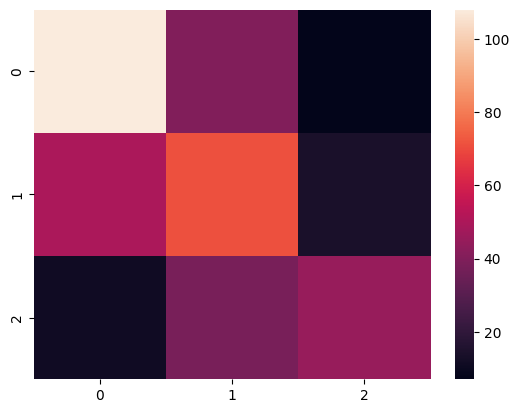

In [93]:
# Create Logistic Regression Model.
log_reg = LogisticRegression(max_iter=100000)

# Train the model
log_reg.fit(X_train, y_train)

# Make a prediction
y_pred_log = log_reg.predict(X_test)

# Calculate the Logistic Regression scores
mse = mean_squared_error(y_test, y_pred_log)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_log)
accuracy = accuracy_score(y_test, y_pred_log)

# Print out the scores.
print("Score testing data:", log_reg.score(X_test, y_test))
print("Score training data:", log_reg.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_log))
print("Cross Validation Score:", cross_val_score(log_reg, X, y))
sns.heatmap(confusion_matrix(y_test, y_pred_log))
plt.show()

#### Random Forest Classifier

Score testing data: 0.5520833333333334
Score training data: 1.0
Mean Squared Error: 0.6197916666666666
Root Mean Squared Error: 0.7872684844871326
R-Square: 0.005473638391642388
Accuracy Score: 0.5520833333333334
              precision    recall  f1-score   support

           0       0.63      0.65      0.64       155
           1       0.45      0.53      0.49       135
           2       0.61      0.41      0.49        94

    accuracy                           0.55       384
   macro avg       0.56      0.53      0.54       384
weighted avg       0.56      0.55      0.55       384

Cross Validation Score: [0.50496866 0.49441981 0.53095857 0.49082569 0.45993884]


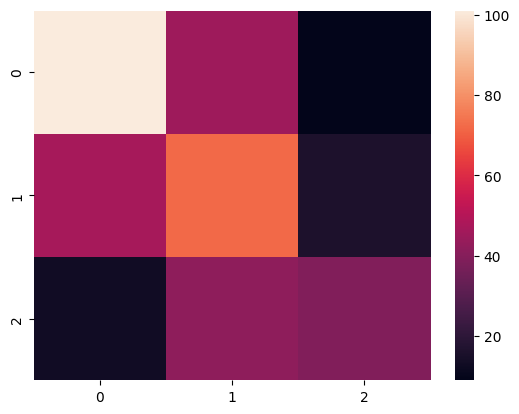

In [94]:
# Create the Model
clf = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=91)

# Train model
clf.fit(X_train, y_train)
  
# Predict the result
y_pred_clf = clf.predict(X_test)

# Calculating the scores
mse = mean_squared_error(y_test, y_pred_clf)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_clf)
accuracy = accuracy_score(y_test, y_pred_clf)
  
# Print out the RandomForestClassifier scores
print("Score testing data:", clf.score(X_test, y_test))
print("Score training data:", clf.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_clf))
print("Cross Validation Score:", cross_val_score(clf, X, y))
sns.heatmap(confusion_matrix(y_test, y_pred_clf))
plt.show()

RandomForest seems to overfit a lot, it scores perfectly on the training data, but scores by 50% on testing data, so this model didn't get tuned correctly and also wouldn't fit well with this data.

#### Gradient Boosting Trees

Score testing data: 0.5703125
Score training data: 0.8314732142857143
Mean Squared Error: 0.609375
Root Mean Squared Error: 0.7806247497997998
R-Square: 0.02218836715816941
Accuracy Score: 0.5703125
              precision    recall  f1-score   support

           0       0.62      0.63      0.63       155
           1       0.48      0.53      0.50       135
           2       0.65      0.52      0.58        94

    accuracy                           0.57       384
   macro avg       0.58      0.56      0.57       384
weighted avg       0.58      0.57      0.57       384



Cross Validation Score: [0.54104877 0.52560771 0.55373796 0.48883792 0.47859327]


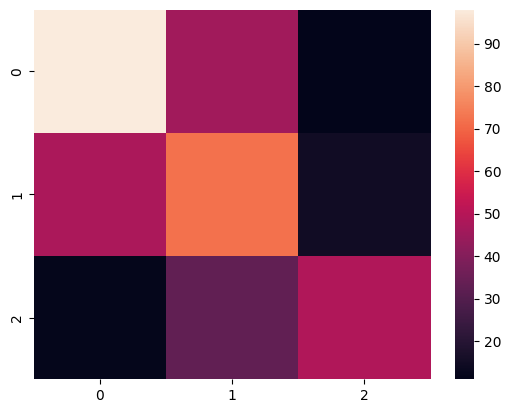

In [95]:
# Initiate the gradient booster classifier
gb = XGBClassifier(max_depth=2, n_estimators=105)

# Train the model.
gb.fit(X_train, y_train)

# Predict the values
y_pred_gb = gb.predict(X_test)

# Calculate scores.
mse = mean_squared_error(y_test, y_pred_gb)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

# Print out the performances of the model.
print("Score testing data:", gb.score(X_test, y_test))
print("Score training data:", gb.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_gb))
print("Cross Validation Score:", cross_val_score(gb, X, y))
sns.heatmap(confusion_matrix(y_test, y_pred_gb))
plt.show()

GradientBoosting also overfits too much, which is weird considering the parameters which I found were the best fit for these models.

I will first compare the models I just used for Goalkeepers. I think Logistic Regression is best fitted for the goalkeepers, because the accuracy, precision, recall, f1-score and Cross-validation scores are all generally higher than in other models. This model also gives the lowest MSE and RMSE of all the models. The Confusion Matrices don't seem to have a very noticable difference between the Gradient Boosting and Logistic Regression models. Another reason that I chose Logistic Regression is because Gradient Boosting and Random Forest seem to overfit the training data a lot, while Logistic Regression doesn't.

#### Attackers

#### Pipeline

In [96]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(att_X, att_y, test_size=0.3, random_state=42)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(att_X, att_y_lin, test_size=0.3, random_state=42)

#### Linear Regression

In [97]:
# Create the Linear Regression Model
lr = LinearRegression()
# Train the model
lr.fit(X_train_lin, y_train_lin)

# Predict using the test set
y_pred_lin = lr.predict(X_test_lin)

# Calculate the Linear Regression scores.
mse = mean_squared_error(y_test_lin, y_pred_lin)
rmse = mse ** 0.5
r2 = r2_score(y_test_lin, y_pred_lin)

# Print out the Linear Regression scores.
print("Score testing data:", lr.score(X_test_lin, y_test_lin))
print("Score training data:", lr.score(X_train_lin, y_train_lin))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Cross Validation Score:", cross_val_score(lr, X, y))

Score testing data: 0.16097496599652916
Score training data: 0.1702388938468521
Mean Squared Error: 2428222726245.2524
Root Mean Squared Error: 1558275.5617172632
R-Square: 0.16097496599652916
Cross Validation Score: [0.05256356 0.04590991 0.05634342 0.02373568 0.13647904]


#### Logistic Regression

Score testing data: 0.5764705882352941
Score training data: 0.5841940907999039
Mean Squared Error: 0.5529411764705883
Root Mean Squared Error: 0.7436001455557875
R-Square: 0.11068962384154113
Accuracy Score: 0.5764705882352941
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       654
           1       0.49      0.57      0.53       657
           2       0.59      0.49      0.53       474

    accuracy                           0.58      1785
   macro avg       0.59      0.57      0.57      1785
weighted avg       0.59      0.58      0.58      1785

Cross Validation Score: [0.52056261 0.50175814 0.51949243 0.49923547 0.47568807]


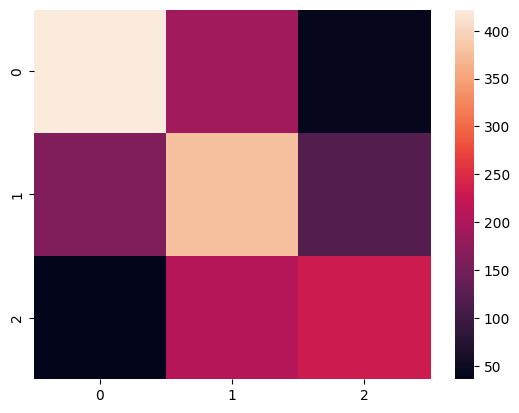

In [98]:
# Create Logistic Regression Model.
log_reg = LogisticRegression(max_iter=100000)

# Train the model
log_reg.fit(X_train, y_train)

# Make a prediction
y_pred_log = log_reg.predict(X_test)

# Calculate the Logistic Regression scores
mse = mean_squared_error(y_test, y_pred_log)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_log)
accuracy = accuracy_score(y_test, y_pred_log)

# Print out the scores.
print("Score testing data:", log_reg.score(X_test, y_test))
print("Score training data:", log_reg.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_log))
print("Cross Validation Score:", cross_val_score(log_reg, X, y))
sns.heatmap(confusion_matrix(y_test, y_pred_log))
plt.show()

#### Random Forest Classifier

Score testing data: 0.5647058823529412
Score training data: 0.6430458803747298
Mean Squared Error: 0.5478991596638656
Root Mean Squared Error: 0.7402021073084469
R-Square: 0.11879883699800131
Accuracy Score: 0.5647058823529412
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       654
           1       0.47      0.60      0.53       657
           2       0.61      0.46      0.52       474

    accuracy                           0.56      1785
   macro avg       0.58      0.56      0.56      1785
weighted avg       0.58      0.56      0.57      1785

Cross Validation Score: [0.53600367 0.51521174 0.54242471 0.48470948 0.48440367]


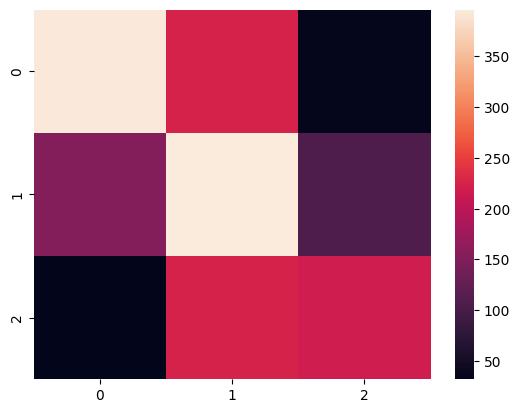

In [99]:
# Create the Model
clf = RandomForestClassifier(max_depth=6, min_samples_split=4, n_estimators=92)

# Train model
clf.fit(X_train, y_train)
  
# Predict the result
y_pred_clf = clf.predict(X_test)

# Calculating the scores
mse = mean_squared_error(y_test, y_pred_clf)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_clf)
accuracy = accuracy_score(y_test, y_pred_clf)
  
# Print out the RandomForestClassifier scores
print("Score testing data:", clf.score(X_test, y_test))
print("Score training data:", clf.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_clf))
print("Cross Validation Score:", cross_val_score(clf, X, y))
sns.heatmap(confusion_matrix(y_test, y_pred_clf))
plt.show()

#### Gradient Boosting Trees

Score testing data: 0.5568627450980392
Score training data: 0.6596204660100888
Mean Squared Error: 0.5994397759103641
Root Mean Squared Error: 0.774234961694681
R-Square: 0.03590465806529797
Accuracy Score: 0.5568627450980392
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       654
           1       0.47      0.57      0.52       657
           2       0.59      0.49      0.53       474

    accuracy                           0.56      1785
   macro avg       0.57      0.55      0.56      1785
weighted avg       0.57      0.56      0.56      1785



Cross Validation Score: [0.54089589 0.52300871 0.55236202 0.4940367  0.48012232]


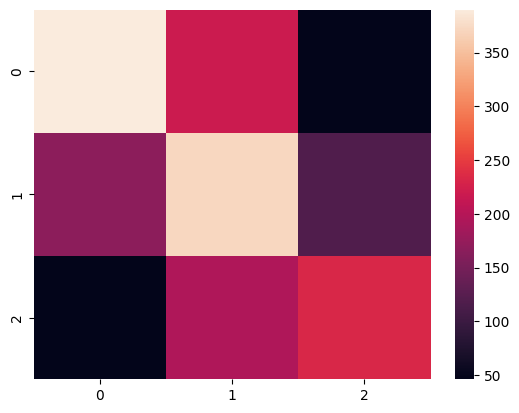

In [100]:
# Initiate the gradient booster classifier
gb = XGBClassifier(max_depth=2, n_estimators=60)

# Train the model.
gb.fit(X_train, y_train)

# Predict the values
y_pred_gb = gb.predict(X_test)

# Calculate scores.
mse = mean_squared_error(y_test, y_pred_gb)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

# Print out the performances of the model.
print("Score testing data:", gb.score(X_test, y_test))
print("Score training data:", gb.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_gb))
print("Cross Validation Score:", cross_val_score(gb, X, y))
# Create a heatmap for confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_gb))
plt.show()

For attackers, I have decided on Logistic Regression. It scores the best on accuracy, recall, precision, f1 and all other scores. It also doesn't overfit as much as Random Forest and Gradient Boosting. the confusion matrix doesn't seem to have a noticable difference.

#### Defenders and MidFielders

#### Pipeline

In [101]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(mid_def_X, mid_def_y, test_size=0.3, random_state=42)
X_train_lin, X_test_lin, y_train_lin, y_test_lin = train_test_split(mid_def_X, mid_def_y_lin, test_size=0.3, random_state=42)

#### Linear Regression

In [102]:
# Create the Linear Regression Model
lr = LinearRegression()
# Train the model
lr.fit(X_train_lin, y_train_lin)

# Predict using the test set
y_pred_lin = lr.predict(X_test_lin)

# Calculate the Linear Regression scores.
mse = mean_squared_error(y_test_lin, y_pred_lin)
rmse = mse ** 0.5
r2 = r2_score(y_test_lin, y_pred_lin)

# Print out the Linear Regression scores.
print("Score testing data:", lr.score(X_test_lin, y_test_lin))
print("Score training data:", lr.score(X_train_lin, y_train_lin))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Cross Validation Score:", cross_val_score(lr, X, y))

Score testing data: 0.11814535927530223
Score training data: 0.16645411354799466
Mean Squared Error: 2314379762248.129
Root Mean Squared Error: 1521308.5690444687
R-Square: 0.11814535927530223
Cross Validation Score: [0.05256356 0.04590991 0.05634342 0.02373568 0.13647904]


#### Logistic Regression

Score testing data: 0.6001045478306325
Score training data: 0.5870028011204482
Mean Squared Error: 0.5261369576581286
Root Mean Squared Error: 0.7253529883154329
R-Square: 0.09901128859572916
Accuracy Score: 0.6001045478306325
              precision    recall  f1-score   support

           0       0.68      0.65      0.66      1376
           1       0.55      0.63      0.59      1536
           2       0.59      0.48      0.53       914

    accuracy                           0.60      3826
   macro avg       0.60      0.59      0.59      3826
weighted avg       0.60      0.60      0.60      3826

Cross Validation Score: [0.52056261 0.50175814 0.51949243 0.49923547 0.47568807]


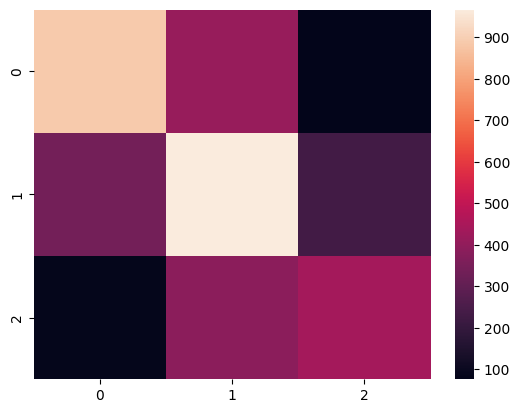

In [103]:
# Create Logistic Regression Model.
log_reg = LogisticRegression(max_iter=100000)

# Train the model
log_reg.fit(X_train, y_train)

# Make a prediction
y_pred_log = log_reg.predict(X_test)

# Calculate the Logistic Regression scores
mse = mean_squared_error(y_test, y_pred_log)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_log)
accuracy = accuracy_score(y_test, y_pred_log)

# Print out the scores.
print("Score testing data:", log_reg.score(X_test, y_test))
print("Score training data:", log_reg.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_log))
print("Cross Validation Score:", cross_val_score(log_reg, X, y))
sns.heatmap(confusion_matrix(y_test, y_pred_log))
plt.show()

#### Random Forest Classifier

Score testing data: 0.6076842655514898
Score training data: 0.6192717086834734
Mean Squared Error: 0.4644537375849451
Root Mean Squared Error: 0.6815084281099869
R-Square: 0.20464136107034814
Accuracy Score: 0.6076842655514898
              precision    recall  f1-score   support

           0       0.76      0.57      0.65      1376
           1       0.53      0.73      0.61      1536
           2       0.62      0.46      0.52       914

    accuracy                           0.61      3826
   macro avg       0.64      0.59      0.60      3826
weighted avg       0.63      0.61      0.61      3826

Cross Validation Score: [0.53371044 0.51628191 0.54104877 0.48562691 0.48333333]


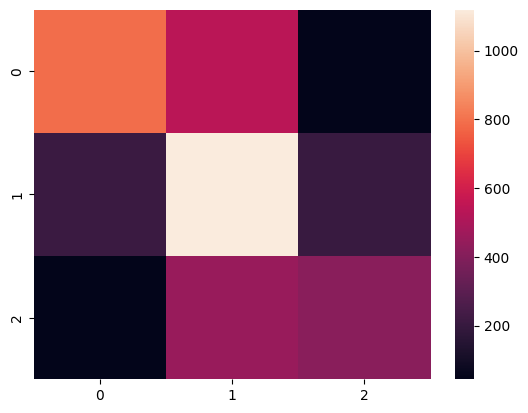

In [104]:
# Create the Model
# clf = RandomForestClassifier(max_depth=6, min_samples_split=2, n_estimators=50)
clf = RandomForestClassifier(max_depth=6, min_samples_split=6, n_estimators=200)

# Train model
clf.fit(X_train, y_train)
  
# Predict the result
y_pred_clf = clf.predict(X_test)

# Calculating the scores
mse = mean_squared_error(y_test, y_pred_clf)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_clf)
accuracy = accuracy_score(y_test, y_pred_clf)
  
# Print out the RandomForestClassifier scores
print("Score testing data:", clf.score(X_test, y_test))
print("Score training data:", clf.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_clf))
print("Cross Validation Score:", cross_val_score(clf, X, y))
sns.heatmap(confusion_matrix(y_test, y_pred_clf))
plt.show()

#### Gradient Boosting Trees

Score testing data: 0.6199686356508103
Score training data: 0.630140056022409
Mean Squared Error: 0.46628332462101413
Root Mean Squared Error: 0.6828494157726241
R-Square: 0.2015082657003382
Accuracy Score: 0.6199686356508103
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1376
           1       0.55      0.68      0.61      1536
           2       0.60      0.49      0.54       914

    accuracy                           0.62      3826
   macro avg       0.63      0.60      0.61      3826
weighted avg       0.63      0.62      0.62      3826



Cross Validation Score: [0.54196606 0.52576059 0.55526678 0.49235474 0.48134557]


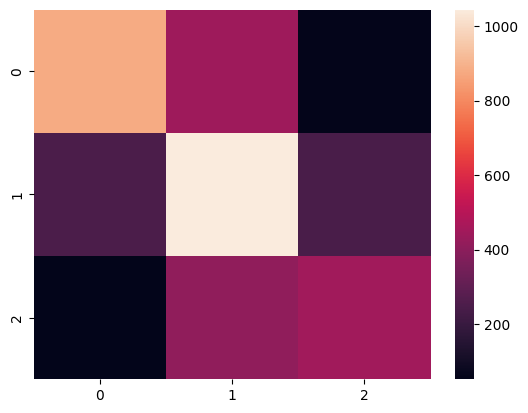

In [105]:
# Initiate the gradient booster classifier
gb = XGBClassifier(max_depth=2, n_estimators=52)

# Train the model.
gb.fit(X_train, y_train)

# Predict the values
y_pred_gb = gb.predict(X_test)

# Calculate scores.
mse = mean_squared_error(y_test, y_pred_gb)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_gb)
accuracy = accuracy_score(y_test, y_pred_gb)

# Print out the performances of the model.
print("Score testing data:", gb.score(X_test, y_test))
print("Score training data:", gb.score(X_train, y_train))
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)
print("R-Square:", r2)
print("Accuracy Score:", accuracy)
print(classification_report(y_test, y_pred_gb))
print("Cross Validation Score:", cross_val_score(gb, X, y))
# Create a heatmap for confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_gb))
plt.show()

For Defenders and MidFielders, Gradient Boosting Trees seems to have the better performance, but it is also a close one with Random Forest: Gradient Boosting scores better on precision, f1-score, accuracy, Cross-validation scores and R-square. Random Forest seems to score a little bit better on MSE and RMSE. The confusion matrices also seems slightly different between the two. The confusion matrix for Random Forest seems to be a little bit less accurate than that of Gradient Boosting. With all of this information I come to the conclusion that Gradient Boosting is the better fit as model for Defenders and MidFielders. One problem is that Gradient Boosting does overfit the training data by a little bit, but the small amount isn't much of a problem.

✍️ Since I have 3 datasets to use, I chose 3 models which are the best fits. 
- Let's first start with Goalkeepers, Logistic Regression is the best model for the Goalkeepers, because this model has the best scores in terms of accuracy, precision, recall, f1, MSE, RMSE and R-square. The confusion matrices don't have too much difference with this dataset.
- For attackers, Logistic Regression is the best performing model. It scores the best on accuracy, recall, precision, f1 and all other scores. It also doesn't overfit as much as Random Forest and Gradient Boosting. The confusion matrix doesn't seem to differ as much. Gradient Boosting does score higher slightly on Cross-validation scores, but due to all other scores I chose Logistic Regression.
- Lastly, the best performing model of all is for Defenders and MidFielders. This was another close call between Gradient Boosting and Random Forest: Gradient Boosting performs better on precision, f1-score, accuracy and R-square, but Random Forest performs slightly better on recall, MSE and RMSE. The last scores to look at is the confusion matrix: Gradient Boosting scores slightly better on the confusion matrix as well, making it the better model for Defenders and MidFielders. One problem is the slight overfitting, the overfitting isn't as high luckily.